In [5]:
import pandas as pd
import numpy as np
import torch as th
import zipfile
from tqdm.auto import tqdm, trange
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import torch_geometric as pyg
import zipfile, os
import torch
import copy
from torch import nn
import networkx as nx
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import trange
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


import torch
import torch_geometric
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid
import torch.optim as optim
import joblib
import gc
from scipy.optimize import root_scalar

pd.set_option("display.max_columns", 100)
PATH_DATA0 = './data/00.01'
PATH_DATA = './data/00.02'
RANDOM_SEED =0
np.random.seed(RANDOM_SEED)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


# Hyperparameters

In [2]:
CRITERION = nn.BCEWithLogitsLoss()
LR = 0.001
TOLERANCE = 20
LR_TOLERANCE= 5
MAX_EPOCHS = 200
BATCH_SIZE =2

# Loaders

In [3]:
loader_train = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_train.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = True)
loader_val = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl')).tolist(),batch_size = BATCH_SIZE
    ,shuffle = False)
loader_test = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl')).tolist(),batch_size = BATCH_SIZE
    ,shuffle = False)

# Model Architecture

In [4]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RelationalModel, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), 
                 nn.ReLU()]
        if n_layers>=2:
            for _ in range(n_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, output_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
class ObjectModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(ObjectModel, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), 
                 nn.ReLU()]
        if n_layers>=2:
            for _ in range(n_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, output_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, C):
        return self.layers(C)
class InteractionNetwork(MessagePassing):
    def __init__(self, hidden_size, n_layers):
        super(InteractionNetwork, self).__init__(aggr='add', 
                                                 flow='source_to_target')
        self.R1 = RelationalModel(10, 4, hidden_size, n_layers)
        self.O = ObjectModel(7, 3, hidden_size, n_layers)
        self.R2 = RelationalModel(10, 1, hidden_size, n_layers)
        self.E: Tensor = Tensor()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:

        # propagate_type: (x: Tensor, edge_attr: Tensor)
        x_tilde = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=None)

        m2 = torch.cat([x_tilde[edge_index[1]],
                        x_tilde[edge_index[0]],
                        self.E], dim=1)
        return self.R2(m2)

    def message(self, x_i, x_j, edge_attr):
        # x_i --> incoming
        # x_j --> outgoing        
        m1 = torch.cat([x_i, x_j, edge_attr], dim=1)
        self.E = self.R1(m1)
        return self.E

    def update(self, aggr_out, x):
        c = torch.cat([x, aggr_out], dim=1)
        return self.O(c) 

# Functions

In [5]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params
def evaluate(model, loader):
    model.eval()
    preds, actuals = [],[]
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds.append(torch.sigmoid(model(batch.x, batch.edge_index, batch.edge_attr)))
            actuals.append(batch.y)
        preds = torch.cat(preds)
        actuals = torch.cat(actuals)
        acc = ((preds>0.5)==(actuals>0.5)).type(torch.float).mean().item()
        entropy = CRITERION(preds, actuals.float()).item()
    model.train()
    return preds.cpu().numpy(), actuals.cpu().numpy(), acc, entropy
def train_epoch(model, loader_train,optimizer):
    model.train()
    train_loss = 0.0
    for batch in tqdm(loader_train, leave = False):
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = CRITERION(output, batch.y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(loader_train)    
    return train_loss


# Train

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

2 1000000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4632 |    0.4105 |   0.9426 |    0.9443 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2433 |    0.3980 |   0.9587 |    0.9598 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2000 |    0.3963 |   0.9591 |    0.9600 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1711 |    0.3909 |   0.9684 |    0.9690 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1495 |    0.3882 |   0.9740 |    0.9749 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.1356 |    0.3862 |   0.9766 |    0.9775 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.1231 |    0.3849 |   0.9780 |    0.9786 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.1118 |    0.3834 |   0.9809 |    0.9817 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.1010 |    0.3821 |   0.9828 |    0.9835 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0931 |    0.3818 |   0.9829 |    0.9837 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0878 |    0.3807 |   0.9846 |    0.9852 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0856 |    0.3803 |   0.9851 |    0.9856 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0803 |    0.3799 |   0.9858 |    0.9865 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0766 |    0.3808 |   0.9840 |    0.9842


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0756 |    0.3796 |   0.9859 |    0.9865 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0714 |    0.3790 |   0.9870 |    0.9877 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0703 |    0.3790 |   0.9869 |    0.9875 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0677 |    0.3792 |   0.9869 |    0.9874


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0683 |    0.3787 |   0.9872 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0662 |    0.3789 |   0.9876 |    0.9881


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0644 |    0.3786 |   0.9874 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0638 |    0.3787 |   0.9879 |    0.9885


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0614 |    0.3786 |   0.9880 |    0.9885


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0618 |    0.3787 |   0.9878 |    0.9883


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0599 |    0.3778 |   0.9889 |    0.9893 *


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0590 |    0.3779 |   0.9887 |    0.9892


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0585 |    0.3780 |   0.9886 |    0.9890


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0573 |    0.3779 |   0.9887 |    0.9893


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0558 |    0.3777 |   0.9892 |    0.9895 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0555 |    0.3779 |   0.9889 |    0.9894


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0552 |    0.3775 |   0.9893 |    0.9896 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0544 |    0.3773 |   0.9898 |    0.9901 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0536 |    0.3773 |   0.9895 |    0.9899


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0518 |    0.3773 |   0.9891 |    0.9894


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0515 |    0.3772 |   0.9896 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0505 |    0.3770 |   0.9898 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0500 |    0.3768 |   0.9900 |    0.9904 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0493 |    0.3770 |   0.9900 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0485 |    0.3763 |   0.9904 |    0.9908 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0481 |    0.3765 |   0.9905 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0478 |    0.3767 |   0.9902 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0474 |    0.3768 |   0.9903 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0471 |    0.3768 |   0.9904 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0460 |    0.3770 |   0.9902 |    0.9905
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0454 |    0.3763 |   0.9910 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0451 |    0.3766 |   0.9904 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0445 |    0.3766 |   0.9905 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0452 |    0.3765 |   0.9909 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0433 |    0.3768 |   0.9898 |    0.9901


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0433 |    0.3763 |   0.9907 |    0.9911 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0426 |    0.3765 |   0.9908 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0425 |    0.3760 |   0.9909 |    0.9913 *


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0431 |    0.3762 |   0.9910 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0424 |    0.3764 |   0.9910 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0415 |    0.3759 |   0.9909 |    0.9913 *


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0405 |    0.3759 |   0.9911 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0405 |    0.3763 |   0.9908 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0400 |    0.3758 |   0.9915 |    0.9918 *


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0394 |    0.3759 |   0.9916 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0400 |    0.3758 |   0.9915 |    0.9918 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0392 |    0.3762 |   0.9911 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0387 |    0.3759 |   0.9913 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0390 |    0.3759 |   0.9915 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0379 |    0.3761 |   0.9913 |    0.9916


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0380 |    0.3758 |   0.9916 |    0.9920 *


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0375 |    0.3758 |   0.9915 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0371 |    0.3758 |   0.9915 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0370 |    0.3757 |   0.9915 |    0.9920 *


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0371 |    0.3758 |   0.9914 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0370 |    0.3756 |   0.9918 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0362 |    0.3760 |   0.9913 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0356 |    0.3760 |   0.9914 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0360 |    0.3755 |   0.9915 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0356 |    0.3755 |   0.9916 |    0.9920 *


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0348 |    0.3754 |   0.9918 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0348 |    0.3753 |   0.9918 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0354 |    0.3756 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0346 |    0.3757 |   0.9913 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0345 |    0.3753 |   0.9921 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0342 |    0.3755 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0333 |    0.3755 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0350 |    0.3755 |   0.9917 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0336 |    0.3753 |   0.9920 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0335 |    0.3753 |   0.9920 |    0.9923
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0329 |    0.3752 |   0.9923 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0333 |    0.3756 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0325 |    0.3752 |   0.9921 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0316 |    0.3754 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0326 |    0.3755 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0330 |    0.3756 |   0.9916 |    0.9919
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0316 |    0.3751 |   0.9923 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0312 |    0.3753 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0308 |    0.3751 |   0.9922 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0309 |    0.3755 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0311 |    0.3753 |   0.9922 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0313 |    0.3752 |   0.9922 |    0.9925
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0300 |    0.3753 |   0.9923 |    0.9927
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0308 |    0.3753 |   0.9920 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0302 |    0.3752 |   0.9923 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0298 |    0.3753 |   0.9918 |    0.9921
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0298 |    0.3751 |   0.9922 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0294 |    0.3750 |   0.9923 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0296 |    0.3751 |   0.9923 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0295 |    0.3753 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0290 |    0.3752 |   0.9922 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0290 |    0.3751 |   0.9922 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0295 |    0.3751 |   0.9922 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0288 |    0.3751 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0283 |    0.3751 |   0.9922 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0285 |    0.3752 |   0.9921 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0287 |    0.3751 |   0.9920 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0284 |    0.3749 |   0.9925 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0283 |    0.3754 |   0.9916 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0287 |    0.3750 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0277 |    0.3749 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0272 |    0.3749 |   0.9923 |    0.9925 *


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0270 |    0.3750 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0276 |    0.3749 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0274 |    0.3749 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0264 |    0.3751 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0263 |    0.3749 |   0.9925 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0273 |    0.3751 |   0.9924 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0267 |    0.3749 |   0.9925 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0258 |    0.3750 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0258 |    0.3749 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0262 |    0.3749 |   0.9925 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0261 |    0.3750 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0261 |    0.3749 |   0.9926 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0254 |    0.3749 |   0.9925 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0260 |    0.3749 |   0.9922 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0249 |    0.3751 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0250 |    0.3748 |   0.9924 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0258 |    0.3750 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0256 |    0.3749 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0250 |    0.3750 |   0.9922 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0255 |    0.3750 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0248 |    0.3748 |   0.9927 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0253 |    0.3749 |   0.9924 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0248 |    0.3748 |   0.9926 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0241 |    0.3747 |   0.9926 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0242 |    0.3747 |   0.9926 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0245 |    0.3750 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0239 |    0.3747 |   0.9926 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0238 |    0.3749 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0246 |    0.3748 |   0.9926 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0234 |    0.3747 |   0.9925 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0238 |    0.3748 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0251 |    0.3749 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0233 |    0.3746 |   0.9928 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0234 |    0.3747 |   0.9927 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0236 |    0.3747 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0228 |    0.3748 |   0.9926 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0232 |    0.3747 |   0.9926 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0223 |    0.3746 |   0.9927 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0228 |    0.3748 |   0.9926 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0237 |    0.3748 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0230 |    0.3747 |   0.9927 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0222 |    0.3749 |   0.9923 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0235 |    0.3746 |   0.9929 |    0.9931 *


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0224 |    0.3746 |   0.9928 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0223 |    0.3747 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0223 |    0.3746 |   0.9927 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0219 |    0.3746 |   0.9927 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0216 |    0.3747 |   0.9928 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0231 |    0.3748 |   0.9927 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0216 |    0.3745 |   0.9929 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0215 |    0.3747 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0221 |    0.3747 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0218 |    0.3746 |   0.9929 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0210 |    0.3745 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0210 |    0.3746 |   0.9927 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0212 |    0.3745 |   0.9928 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0213 |    0.3747 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0218 |    0.3747 |   0.9928 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  175 |     0.0212 |    0.3745 |   0.9929 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  176 |     0.0213 |    0.3748 |   0.9926 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  177 |     0.0211 |    0.3748 |   0.9925 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  178 |     0.0202 |    0.3746 |   0.9926 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  179 |     0.0217 |    0.3746 |   0.9926 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  180 |     0.0208 |    0.3747 |   0.9927 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  181 |     0.0203 |    0.3746 |   0.9928 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  182 |     0.0207 |    0.3751 |   0.9921 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  183 |     0.0207 |    0.3747 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  184 |     0.0204 |    0.3748 |   0.9924 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  185 |     0.0206 |    0.3748 |   0.9926 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  186 |     0.0195 |    0.3744 |   0.9930 |    0.9932 *


  0%|          | 0/283 [00:00<?, ?it/s]

  187 |     0.0202 |    0.3746 |   0.9927 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  188 |     0.0202 |    0.3748 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  189 |     0.0198 |    0.3746 |   0.9927 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  190 |     0.0210 |    0.3745 |   0.9928 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

  191 |     0.0199 |    0.3744 |   0.9929 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

  192 |     0.0207 |    0.3759 |   0.9905 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

  193 |     0.0213 |    0.3745 |   0.9928 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  194 |     0.0192 |    0.3745 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

  195 |     0.0197 |    0.3746 |   0.9928 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  196 |     0.0193 |    0.3747 |   0.9927 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  197 |     0.0196 |    0.3744 |   0.9929 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  198 |     0.0195 |    0.3747 |   0.9926 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  199 |     0.0189 |    0.3745 |   0.9929 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  200 |     0.0189 |    0.3746 |   0.9926 |    0.9928
LR reduction to 1.0000000000000003e-09


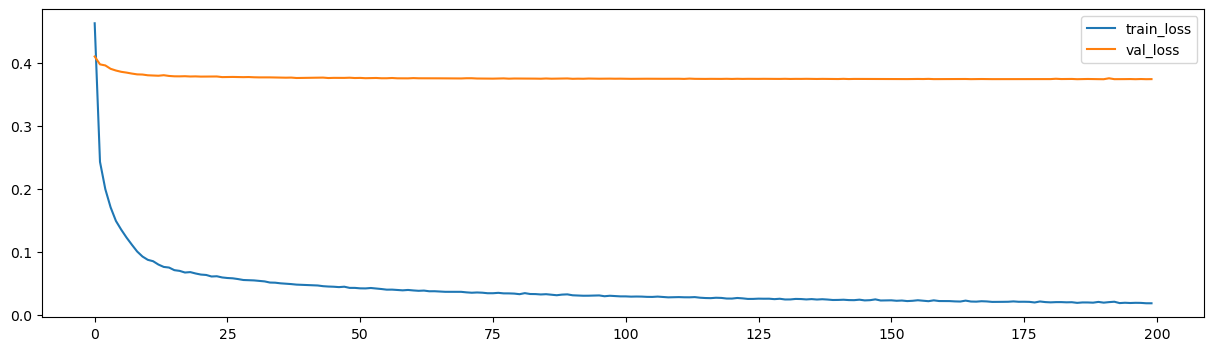

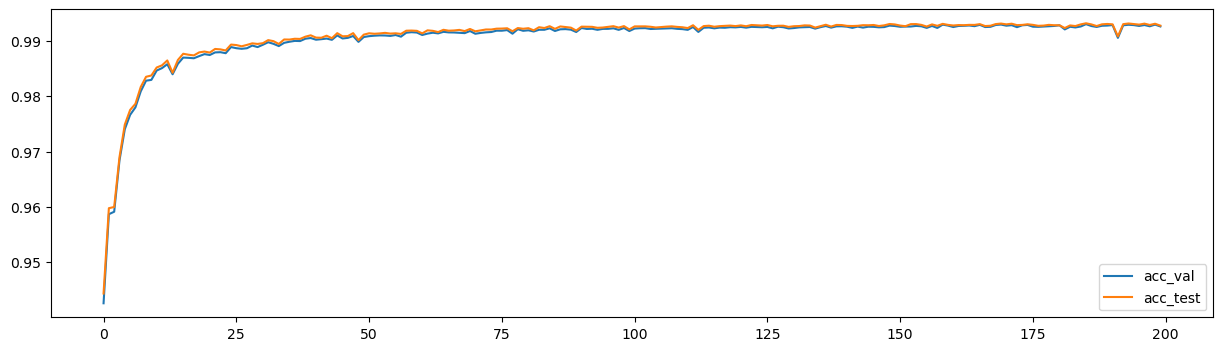

2 100000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4796 |    0.4119 |   0.9357 |    0.9381 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2772 |    0.4011 |   0.9533 |    0.9546 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2331 |    0.3989 |   0.9567 |    0.9579 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.2079 |    0.3959 |   0.9615 |    0.9621 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1898 |    0.3942 |   0.9642 |    0.9648 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.1771 |    0.3936 |   0.9634 |    0.9637 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.1684 |    0.3933 |   0.9649 |    0.9659 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.1613 |    0.3911 |   0.9694 |    0.9701 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.1555 |    0.3914 |   0.9682 |    0.9685


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.1488 |    0.3892 |   0.9707 |    0.9716 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.1453 |    0.3905 |   0.9696 |    0.9708


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.1419 |    0.3887 |   0.9728 |    0.9734 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.1352 |    0.3882 |   0.9728 |    0.9735 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.1335 |    0.3882 |   0.9733 |    0.9743 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.1331 |    0.3873 |   0.9744 |    0.9750 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.1249 |    0.3865 |   0.9761 |    0.9766 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.1243 |    0.3865 |   0.9761 |    0.9770


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.1195 |    0.3860 |   0.9765 |    0.9770 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.1180 |    0.3852 |   0.9765 |    0.9771 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.1167 |    0.3850 |   0.9784 |    0.9791 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.1118 |    0.3847 |   0.9788 |    0.9794 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.1116 |    0.3848 |   0.9784 |    0.9794


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.1092 |    0.3843 |   0.9791 |    0.9800 *


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.1062 |    0.3844 |   0.9792 |    0.9798


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.1040 |    0.3848 |   0.9783 |    0.9786


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.1041 |    0.3830 |   0.9807 |    0.9812 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.1007 |    0.3831 |   0.9810 |    0.9819


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.1004 |    0.3828 |   0.9813 |    0.9821 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0979 |    0.3831 |   0.9805 |    0.9813


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0962 |    0.3830 |   0.9812 |    0.9819


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0958 |    0.3826 |   0.9820 |    0.9826 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0932 |    0.3823 |   0.9824 |    0.9830 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0928 |    0.3823 |   0.9815 |    0.9822


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0916 |    0.3824 |   0.9823 |    0.9829


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0893 |    0.3820 |   0.9831 |    0.9837 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0872 |    0.3819 |   0.9827 |    0.9831 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0865 |    0.3815 |   0.9835 |    0.9840 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0850 |    0.3809 |   0.9841 |    0.9848 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0835 |    0.3814 |   0.9844 |    0.9848


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0821 |    0.3805 |   0.9846 |    0.9852 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0831 |    0.3803 |   0.9847 |    0.9853 *


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0806 |    0.3808 |   0.9847 |    0.9851


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0798 |    0.3811 |   0.9842 |    0.9847


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0775 |    0.3803 |   0.9851 |    0.9857


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0773 |    0.3802 |   0.9853 |    0.9859 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0770 |    0.3801 |   0.9852 |    0.9856 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0759 |    0.3802 |   0.9851 |    0.9856


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0754 |    0.3798 |   0.9862 |    0.9866 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0756 |    0.3799 |   0.9860 |    0.9865


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0739 |    0.3798 |   0.9859 |    0.9863 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0734 |    0.3801 |   0.9856 |    0.9860


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0707 |    0.3796 |   0.9864 |    0.9867 *


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0720 |    0.3800 |   0.9859 |    0.9864


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0719 |    0.3793 |   0.9865 |    0.9869 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0716 |    0.3794 |   0.9862 |    0.9867


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0695 |    0.3790 |   0.9868 |    0.9873 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0689 |    0.3794 |   0.9863 |    0.9867


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0691 |    0.3793 |   0.9870 |    0.9873


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0671 |    0.3793 |   0.9864 |    0.9870


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0672 |    0.3789 |   0.9870 |    0.9873 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0679 |    0.3791 |   0.9866 |    0.9868


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0666 |    0.3788 |   0.9875 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0653 |    0.3787 |   0.9873 |    0.9877 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0663 |    0.3785 |   0.9877 |    0.9881 *


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0658 |    0.3786 |   0.9874 |    0.9878


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0650 |    0.3790 |   0.9869 |    0.9875


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0643 |    0.3782 |   0.9879 |    0.9883 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0638 |    0.3790 |   0.9867 |    0.9873


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0637 |    0.3790 |   0.9874 |    0.9878


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0636 |    0.3783 |   0.9879 |    0.9882


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0634 |    0.3785 |   0.9877 |    0.9882


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0623 |    0.3784 |   0.9875 |    0.9880
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0621 |    0.3786 |   0.9874 |    0.9877
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0616 |    0.3781 |   0.9881 |    0.9885 *


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0606 |    0.3780 |   0.9884 |    0.9887 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0613 |    0.3784 |   0.9881 |    0.9884


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0600 |    0.3782 |   0.9881 |    0.9885


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0599 |    0.3787 |   0.9877 |    0.9882


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0602 |    0.3784 |   0.9878 |    0.9882


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0605 |    0.3782 |   0.9879 |    0.9884
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0602 |    0.3782 |   0.9880 |    0.9884
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0588 |    0.3780 |   0.9883 |    0.9886
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0590 |    0.3785 |   0.9877 |    0.9881
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0580 |    0.3787 |   0.9873 |    0.9874
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0580 |    0.3779 |   0.9888 |    0.9891 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0575 |    0.3778 |   0.9887 |    0.9889 *


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0573 |    0.3780 |   0.9887 |    0.9890


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0572 |    0.3782 |   0.9882 |    0.9886


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0567 |    0.3778 |   0.9886 |    0.9889 *


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0564 |    0.3779 |   0.9885 |    0.9889


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0582 |    0.3782 |   0.9880 |    0.9882


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0565 |    0.3776 |   0.9888 |    0.9892 *


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0560 |    0.3777 |   0.9885 |    0.9887


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0550 |    0.3778 |   0.9886 |    0.9888


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0559 |    0.3776 |   0.9890 |    0.9893


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0551 |    0.3775 |   0.9889 |    0.9892 *


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0560 |    0.3777 |   0.9891 |    0.9895


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0548 |    0.3775 |   0.9890 |    0.9894 *


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0538 |    0.3778 |   0.9888 |    0.9890


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0543 |    0.3776 |   0.9890 |    0.9892


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0550 |    0.3778 |   0.9888 |    0.9891


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0542 |    0.3777 |   0.9889 |    0.9892


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0530 |    0.3773 |   0.9893 |    0.9896 *


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0545 |    0.3782 |   0.9883 |    0.9884


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0533 |    0.3775 |   0.9891 |    0.9894


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0527 |    0.3775 |   0.9891 |    0.9894


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0531 |    0.3779 |   0.9885 |    0.9887


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0529 |    0.3775 |   0.9890 |    0.9891
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0524 |    0.3775 |   0.9890 |    0.9893
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0521 |    0.3771 |   0.9897 |    0.9899 *


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0534 |    0.3774 |   0.9893 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0518 |    0.3774 |   0.9892 |    0.9895


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0519 |    0.3773 |   0.9893 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0516 |    0.3774 |   0.9892 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0521 |    0.3772 |   0.9893 |    0.9895
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0509 |    0.3775 |   0.9893 |    0.9895
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0510 |    0.3775 |   0.9891 |    0.9895
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0510 |    0.3773 |   0.9894 |    0.9895
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0513 |    0.3772 |   0.9893 |    0.9896
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0505 |    0.3771 |   0.9894 |    0.9896
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0496 |    0.3772 |   0.9894 |    0.9897
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0505 |    0.3772 |   0.9895 |    0.9896
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0503 |    0.3771 |   0.9895 |    0.9896
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0496 |    0.3771 |   0.9897 |    0.9900
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0497 |    0.3773 |   0.9893 |    0.9894
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0499 |    0.3773 |   0.9892 |    0.9895
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0496 |    0.3775 |   0.9891 |    0.9894
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0497 |    0.3771 |   0.9895 |    0.9898
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0492 |    0.3773 |   0.9891 |    0.9892
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0492 |    0.3770 |   0.9897 |    0.9899 *


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0486 |    0.3771 |   0.9897 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0489 |    0.3770 |   0.9894 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0492 |    0.3772 |   0.9894 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0489 |    0.3771 |   0.9897 |    0.9899


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0489 |    0.3778 |   0.9886 |    0.9889
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0490 |    0.3771 |   0.9896 |    0.9899
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0487 |    0.3773 |   0.9893 |    0.9896
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0488 |    0.3768 |   0.9900 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0478 |    0.3769 |   0.9899 |    0.9902


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0478 |    0.3771 |   0.9895 |    0.9899


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0473 |    0.3771 |   0.9895 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0480 |    0.3773 |   0.9895 |    0.9897


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0477 |    0.3768 |   0.9895 |    0.9899
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0474 |    0.3769 |   0.9895 |    0.9897
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0472 |    0.3770 |   0.9898 |    0.9901
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0470 |    0.3773 |   0.9893 |    0.9897
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0475 |    0.3770 |   0.9894 |    0.9899
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0471 |    0.3768 |   0.9900 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0468 |    0.3768 |   0.9899 |    0.9902


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0468 |    0.3771 |   0.9894 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0470 |    0.3768 |   0.9898 |    0.9901 *


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0467 |    0.3768 |   0.9899 |    0.9902


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0461 |    0.3770 |   0.9895 |    0.9899


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0469 |    0.3767 |   0.9899 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0461 |    0.3767 |   0.9900 |    0.9904 *


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0463 |    0.3769 |   0.9898 |    0.9900


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0455 |    0.3767 |   0.9900 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0461 |    0.3770 |   0.9895 |    0.9897


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0456 |    0.3766 |   0.9901 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0459 |    0.3770 |   0.9900 |    0.9902


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0457 |    0.3769 |   0.9898 |    0.9901


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0462 |    0.3770 |   0.9899 |    0.9900


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0454 |    0.3768 |   0.9902 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0450 |    0.3772 |   0.9891 |    0.9893
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0459 |    0.3766 |   0.9900 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0455 |    0.3765 |   0.9902 |    0.9905 *


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0451 |    0.3778 |   0.9885 |    0.9889


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0453 |    0.3766 |   0.9900 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0446 |    0.3767 |   0.9902 |    0.9905


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0446 |    0.3766 |   0.9903 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0449 |    0.3766 |   0.9900 |    0.9904
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0445 |    0.3771 |   0.9896 |    0.9900
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0452 |    0.3771 |   0.9896 |    0.9899
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0444 |    0.3767 |   0.9902 |    0.9904
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  175 |     0.0442 |    0.3767 |   0.9901 |    0.9904
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  176 |     0.0441 |    0.3768 |   0.9900 |    0.9904
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  177 |     0.0439 |    0.3770 |   0.9899 |    0.9901
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  178 |     0.0443 |    0.3765 |   0.9904 |    0.9906
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  179 |     0.0436 |    0.3764 |   0.9905 |    0.9907 *


  0%|          | 0/283 [00:00<?, ?it/s]

  180 |     0.0438 |    0.3766 |   0.9902 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

  181 |     0.0440 |    0.3772 |   0.9895 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

  182 |     0.0440 |    0.3767 |   0.9902 |    0.9905


  0%|          | 0/283 [00:00<?, ?it/s]

  183 |     0.0431 |    0.3768 |   0.9901 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

  184 |     0.0445 |    0.3765 |   0.9903 |    0.9904
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  185 |     0.0433 |    0.3766 |   0.9898 |    0.9901
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  186 |     0.0435 |    0.3770 |   0.9895 |    0.9899
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  187 |     0.0429 |    0.3766 |   0.9901 |    0.9904
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  188 |     0.0435 |    0.3767 |   0.9897 |    0.9903
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  189 |     0.0443 |    0.3766 |   0.9900 |    0.9903
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  190 |     0.0429 |    0.3765 |   0.9903 |    0.9906
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  191 |     0.0424 |    0.3764 |   0.9904 |    0.9907
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  192 |     0.0429 |    0.3770 |   0.9898 |    0.9901
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  193 |     0.0430 |    0.3764 |   0.9904 |    0.9905
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  194 |     0.0418 |    0.3764 |   0.9904 |    0.9908
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  195 |     0.0432 |    0.3770 |   0.9897 |    0.9899
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  196 |     0.0417 |    0.3766 |   0.9903 |    0.9905
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  197 |     0.0424 |    0.3764 |   0.9906 |    0.9908
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  198 |     0.0423 |    0.3764 |   0.9902 |    0.9906
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  199 |     0.0429 |    0.3766 |   0.9901 |    0.9905
Early stopping at epoch 199


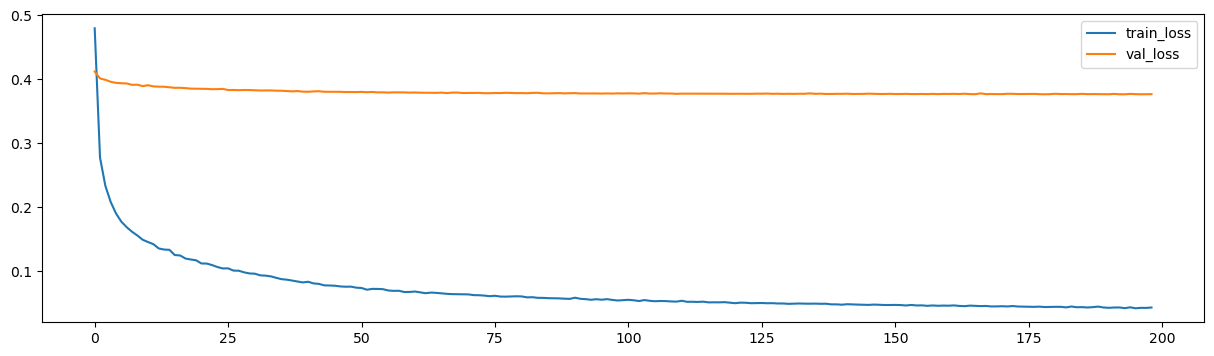

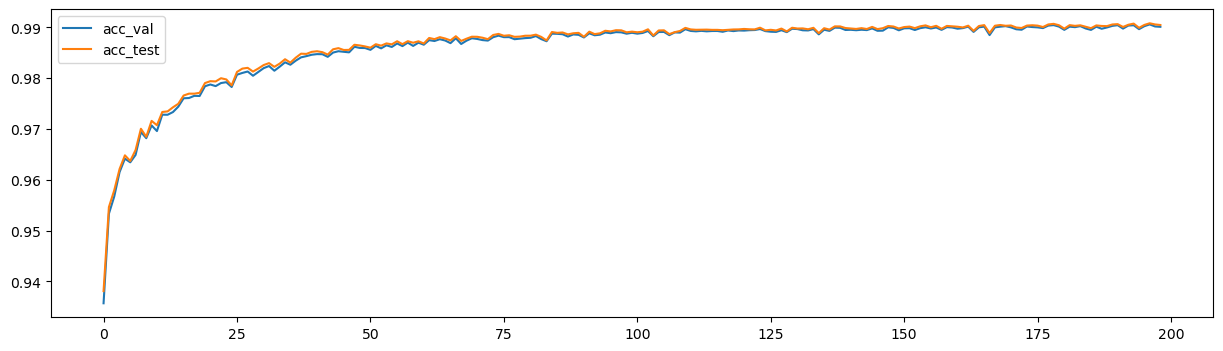

2 500000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4356 |    0.4068 |   0.9444 |    0.9463 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2509 |    0.3999 |   0.9560 |    0.9570 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2014 |    0.3938 |   0.9633 |    0.9643 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1804 |    0.3916 |   0.9678 |    0.9687 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1610 |    0.3897 |   0.9697 |    0.9702 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.1472 |    0.3878 |   0.9741 |    0.9749 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.1351 |    0.3864 |   0.9756 |    0.9768 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.1249 |    0.3844 |   0.9791 |    0.9798 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.1111 |    0.3826 |   0.9818 |    0.9823 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0997 |    0.3825 |   0.9813 |    0.9821 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0914 |    0.3813 |   0.9837 |    0.9846 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0877 |    0.3811 |   0.9845 |    0.9851 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0820 |    0.3802 |   0.9857 |    0.9862 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0792 |    0.3801 |   0.9860 |    0.9863 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0760 |    0.3799 |   0.9860 |    0.9865 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0746 |    0.3791 |   0.9870 |    0.9872 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0721 |    0.3792 |   0.9864 |    0.9869


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0715 |    0.3791 |   0.9868 |    0.9871 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0683 |    0.3789 |   0.9876 |    0.9880 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0661 |    0.3786 |   0.9878 |    0.9881 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0662 |    0.3783 |   0.9881 |    0.9886 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0644 |    0.3782 |   0.9884 |    0.9889 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0637 |    0.3784 |   0.9880 |    0.9885


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0612 |    0.3782 |   0.9884 |    0.9889


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0607 |    0.3782 |   0.9883 |    0.9888


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0589 |    0.3786 |   0.9880 |    0.9886


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0601 |    0.3777 |   0.9888 |    0.9893 *


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0570 |    0.3778 |   0.9888 |    0.9891


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0573 |    0.3775 |   0.9888 |    0.9892 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0568 |    0.3778 |   0.9885 |    0.9888


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0566 |    0.3770 |   0.9896 |    0.9901 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0546 |    0.3775 |   0.9895 |    0.9900


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0536 |    0.3777 |   0.9888 |    0.9892


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0537 |    0.3770 |   0.9898 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0525 |    0.3772 |   0.9898 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0523 |    0.3775 |   0.9893 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0520 |    0.3771 |   0.9899 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0518 |    0.3768 |   0.9903 |    0.9906 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0498 |    0.3767 |   0.9900 |    0.9904 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0493 |    0.3768 |   0.9902 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0491 |    0.3771 |   0.9895 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0491 |    0.3765 |   0.9900 |    0.9904 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0478 |    0.3767 |   0.9903 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0485 |    0.3765 |   0.9907 |    0.9910 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0467 |    0.3763 |   0.9904 |    0.9908 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0462 |    0.3766 |   0.9900 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0464 |    0.3766 |   0.9905 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0456 |    0.3767 |   0.9901 |    0.9905


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0454 |    0.3765 |   0.9907 |    0.9911


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0446 |    0.3761 |   0.9909 |    0.9912 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0440 |    0.3761 |   0.9910 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0439 |    0.3763 |   0.9906 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0434 |    0.3763 |   0.9909 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0428 |    0.3762 |   0.9909 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0438 |    0.3766 |   0.9902 |    0.9906
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0424 |    0.3762 |   0.9912 |    0.9915
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0422 |    0.3762 |   0.9910 |    0.9914
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0421 |    0.3763 |   0.9910 |    0.9914
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0412 |    0.3762 |   0.9909 |    0.9914
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0413 |    0.3759 |   0.9911 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0408 |    0.3760 |   0.9912 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0403 |    0.3761 |   0.9910 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0399 |    0.3761 |   0.9912 |    0.9916


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0408 |    0.3763 |   0.9909 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0396 |    0.3760 |   0.9912 |    0.9916
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0393 |    0.3758 |   0.9914 |    0.9918 *


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0392 |    0.3760 |   0.9912 |    0.9915


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0390 |    0.3759 |   0.9915 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0383 |    0.3760 |   0.9913 |    0.9916


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0382 |    0.3760 |   0.9914 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0374 |    0.3757 |   0.9915 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0371 |    0.3758 |   0.9917 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0373 |    0.3758 |   0.9915 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0374 |    0.3756 |   0.9916 |    0.9920 *


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0369 |    0.3759 |   0.9914 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0369 |    0.3756 |   0.9914 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0369 |    0.3756 |   0.9915 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0365 |    0.3755 |   0.9918 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0352 |    0.3755 |   0.9917 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0359 |    0.3757 |   0.9916 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0355 |    0.3756 |   0.9918 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0355 |    0.3759 |   0.9913 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0347 |    0.3757 |   0.9915 |    0.9918
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0346 |    0.3755 |   0.9919 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0349 |    0.3755 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0349 |    0.3755 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0341 |    0.3758 |   0.9914 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0343 |    0.3759 |   0.9914 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0336 |    0.3754 |   0.9919 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0335 |    0.3755 |   0.9918 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0331 |    0.3754 |   0.9918 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0330 |    0.3754 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0329 |    0.3754 |   0.9918 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0331 |    0.3754 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0323 |    0.3757 |   0.9917 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0319 |    0.3754 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0329 |    0.3752 |   0.9922 |    0.9924 *


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0317 |    0.3753 |   0.9920 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0319 |    0.3753 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0316 |    0.3758 |   0.9917 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0316 |    0.3753 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0315 |    0.3755 |   0.9919 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0309 |    0.3755 |   0.9918 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0307 |    0.3754 |   0.9916 |    0.9921
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0312 |    0.3754 |   0.9919 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0314 |    0.3751 |   0.9920 |    0.9925 *


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0305 |    0.3753 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0300 |    0.3752 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0300 |    0.3753 |   0.9921 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0298 |    0.3753 |   0.9920 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0302 |    0.3753 |   0.9920 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0300 |    0.3753 |   0.9920 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0295 |    0.3754 |   0.9920 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0296 |    0.3750 |   0.9922 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0292 |    0.3751 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0292 |    0.3752 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0293 |    0.3750 |   0.9923 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0295 |    0.3751 |   0.9922 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0286 |    0.3749 |   0.9924 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0286 |    0.3750 |   0.9923 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0285 |    0.3753 |   0.9919 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0292 |    0.3750 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0282 |    0.3751 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0281 |    0.3751 |   0.9920 |    0.9922
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0276 |    0.3750 |   0.9920 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0281 |    0.3752 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0284 |    0.3754 |   0.9915 |    0.9918
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0274 |    0.3750 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0279 |    0.3749 |   0.9924 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0278 |    0.3751 |   0.9922 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0276 |    0.3752 |   0.9921 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0281 |    0.3752 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0268 |    0.3751 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0271 |    0.3751 |   0.9922 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0266 |    0.3750 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0268 |    0.3749 |   0.9925 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0269 |    0.3750 |   0.9922 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0264 |    0.3749 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0265 |    0.3750 |   0.9922 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0265 |    0.3749 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0264 |    0.3748 |   0.9925 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0257 |    0.3750 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0273 |    0.3752 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0258 |    0.3748 |   0.9925 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0258 |    0.3752 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0256 |    0.3749 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0264 |    0.3751 |   0.9920 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0261 |    0.3750 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0267 |    0.3750 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0258 |    0.3748 |   0.9926 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0252 |    0.3749 |   0.9924 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0251 |    0.3749 |   0.9923 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0246 |    0.3748 |   0.9925 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0248 |    0.3749 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0244 |    0.3748 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0254 |    0.3749 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0254 |    0.3749 |   0.9924 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0246 |    0.3748 |   0.9925 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0245 |    0.3748 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0243 |    0.3749 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0252 |    0.3749 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0238 |    0.3749 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0244 |    0.3748 |   0.9924 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0247 |    0.3751 |   0.9920 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0243 |    0.3749 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0239 |    0.3750 |   0.9923 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0235 |    0.3749 |   0.9922 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0240 |    0.3749 |   0.9923 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0240 |    0.3748 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0241 |    0.3749 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0231 |    0.3749 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0238 |    0.3748 |   0.9925 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0232 |    0.3749 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0233 |    0.3746 |   0.9926 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  175 |     0.0230 |    0.3747 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  176 |     0.0237 |    0.3748 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  177 |     0.0235 |    0.3748 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  178 |     0.0233 |    0.3748 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  179 |     0.0226 |    0.3748 |   0.9925 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  180 |     0.0235 |    0.3748 |   0.9926 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  181 |     0.0224 |    0.3748 |   0.9922 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  182 |     0.0226 |    0.3747 |   0.9927 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  183 |     0.0232 |    0.3750 |   0.9921 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  184 |     0.0230 |    0.3747 |   0.9926 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  185 |     0.0225 |    0.3748 |   0.9925 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  186 |     0.0221 |    0.3747 |   0.9924 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  187 |     0.0224 |    0.3747 |   0.9923 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  188 |     0.0232 |    0.3746 |   0.9927 |    0.9931 *


  0%|          | 0/283 [00:00<?, ?it/s]

  189 |     0.0225 |    0.3747 |   0.9926 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  190 |     0.0227 |    0.3750 |   0.9923 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  191 |     0.0214 |    0.3747 |   0.9926 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  192 |     0.0215 |    0.3747 |   0.9926 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  193 |     0.0216 |    0.3746 |   0.9925 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

  194 |     0.0218 |    0.3748 |   0.9925 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  195 |     0.0223 |    0.3747 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  196 |     0.0216 |    0.3747 |   0.9926 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  197 |     0.0221 |    0.3746 |   0.9926 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

  198 |     0.0221 |    0.3746 |   0.9926 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  199 |     0.0209 |    0.3747 |   0.9925 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  200 |     0.0220 |    0.3747 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


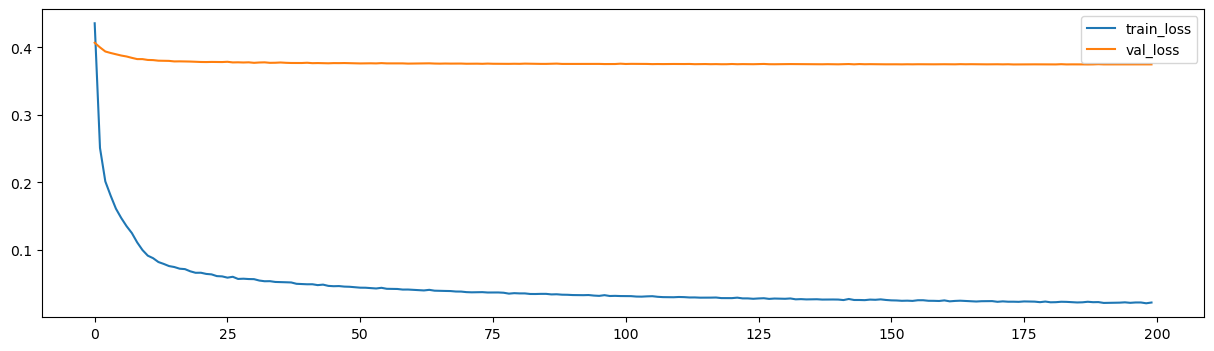

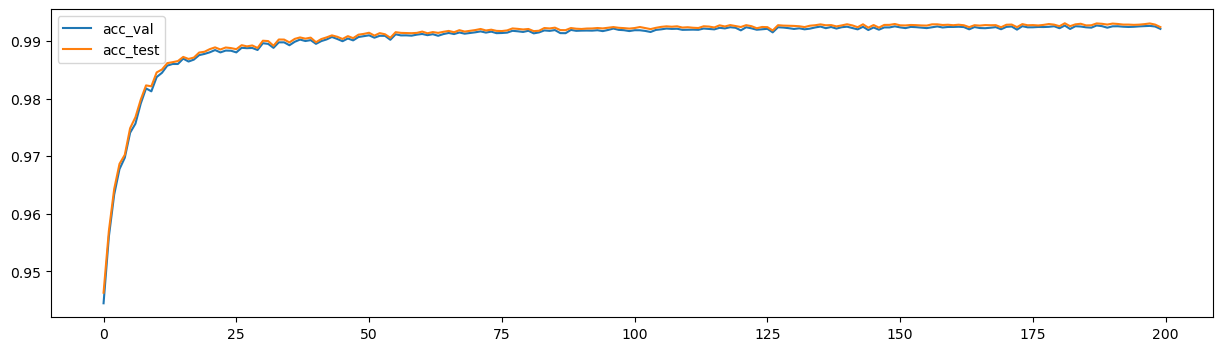

  0%|          | 0/3 [00:00<?, ?it/s]

3 1000000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4088 |    0.4026 |   0.9527 |    0.9539 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2076 |    0.3937 |   0.9631 |    0.9645 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.1583 |    0.3874 |   0.9750 |    0.9757 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1199 |    0.3821 |   0.9819 |    0.9827 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.0944 |    0.3805 |   0.9848 |    0.9856 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.0817 |    0.3804 |   0.9843 |    0.9852 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0761 |    0.3811 |   0.9851 |    0.9860


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0705 |    0.3795 |   0.9869 |    0.9877 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0666 |    0.3787 |   0.9871 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0632 |    0.3781 |   0.9876 |    0.9881 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0617 |    0.3787 |   0.9874 |    0.9879


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0607 |    0.3788 |   0.9882 |    0.9887


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0590 |    0.3777 |   0.9892 |    0.9896 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0561 |    0.3778 |   0.9889 |    0.9891


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0575 |    0.3777 |   0.9891 |    0.9893


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0541 |    0.3775 |   0.9893 |    0.9897 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0563 |    0.3776 |   0.9894 |    0.9899


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0513 |    0.3776 |   0.9893 |    0.9897


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0500 |    0.3771 |   0.9894 |    0.9899 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0500 |    0.3765 |   0.9901 |    0.9903 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0484 |    0.3766 |   0.9905 |    0.9907


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0492 |    0.3770 |   0.9904 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0458 |    0.3766 |   0.9902 |    0.9907


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0460 |    0.3766 |   0.9907 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0456 |    0.3772 |   0.9900 |    0.9902
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0445 |    0.3762 |   0.9914 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0435 |    0.3766 |   0.9906 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0465 |    0.3762 |   0.9914 |    0.9917 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0426 |    0.3761 |   0.9912 |    0.9915 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0406 |    0.3757 |   0.9918 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0415 |    0.3765 |   0.9910 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0401 |    0.3757 |   0.9916 |    0.9917 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0395 |    0.3757 |   0.9916 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0388 |    0.3756 |   0.9917 |    0.9918 *


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0380 |    0.3754 |   0.9921 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0384 |    0.3764 |   0.9908 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0389 |    0.3753 |   0.9922 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0374 |    0.3758 |   0.9915 |    0.9915


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0366 |    0.3759 |   0.9915 |    0.9916


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0357 |    0.3753 |   0.9923 |    0.9924 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0350 |    0.3749 |   0.9926 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0343 |    0.3753 |   0.9926 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0348 |    0.3761 |   0.9915 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0370 |    0.3758 |   0.9918 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0335 |    0.3752 |   0.9927 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0328 |    0.3750 |   0.9930 |    0.9931
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0333 |    0.3752 |   0.9924 |    0.9925
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0324 |    0.3750 |   0.9926 |    0.9927
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0314 |    0.3750 |   0.9927 |    0.9927
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0314 |    0.3747 |   0.9929 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0306 |    0.3751 |   0.9925 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0306 |    0.3748 |   0.9927 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0309 |    0.3749 |   0.9927 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0300 |    0.3747 |   0.9932 |    0.9932 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0296 |    0.3749 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0291 |    0.3746 |   0.9929 |    0.9931 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0289 |    0.3750 |   0.9929 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0281 |    0.3750 |   0.9928 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0288 |    0.3748 |   0.9929 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0282 |    0.3750 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0276 |    0.3747 |   0.9932 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0268 |    0.3746 |   0.9932 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0273 |    0.3746 |   0.9932 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0268 |    0.3746 |   0.9931 |    0.9932 *


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0267 |    0.3745 |   0.9932 |    0.9934 *


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0266 |    0.3748 |   0.9931 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0257 |    0.3747 |   0.9933 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0257 |    0.3746 |   0.9931 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0249 |    0.3747 |   0.9931 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0249 |    0.3744 |   0.9933 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0245 |    0.3746 |   0.9930 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0242 |    0.3742 |   0.9935 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0252 |    0.3748 |   0.9930 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0243 |    0.3744 |   0.9932 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0237 |    0.3747 |   0.9932 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0238 |    0.3744 |   0.9933 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0237 |    0.3744 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0227 |    0.3743 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0228 |    0.3744 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0230 |    0.3744 |   0.9933 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0226 |    0.3743 |   0.9932 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0224 |    0.3744 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0218 |    0.3744 |   0.9933 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0225 |    0.3743 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0210 |    0.3741 |   0.9936 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0217 |    0.3746 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0221 |    0.3744 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0206 |    0.3741 |   0.9935 |    0.9936 *


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0211 |    0.3743 |   0.9935 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0203 |    0.3743 |   0.9933 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0200 |    0.3745 |   0.9931 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0199 |    0.3743 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0208 |    0.3744 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0195 |    0.3743 |   0.9931 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0199 |    0.3742 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0190 |    0.3743 |   0.9933 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0206 |    0.3741 |   0.9938 |    0.9939 *


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0187 |    0.3740 |   0.9936 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0192 |    0.3743 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0193 |    0.3741 |   0.9936 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0188 |    0.3744 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0196 |    0.3741 |   0.9937 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0176 |    0.3741 |   0.9933 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0181 |    0.3742 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0180 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0183 |    0.3741 |   0.9934 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0183 |    0.3745 |   0.9930 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0180 |    0.3742 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0177 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0175 |    0.3745 |   0.9931 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0174 |    0.3740 |   0.9937 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0168 |    0.3745 |   0.9927 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0172 |    0.3740 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0170 |    0.3739 |   0.9938 |    0.9939 *


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0170 |    0.3742 |   0.9933 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0165 |    0.3742 |   0.9935 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0170 |    0.3741 |   0.9935 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0155 |    0.3743 |   0.9932 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0161 |    0.3739 |   0.9937 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0157 |    0.3743 |   0.9932 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0169 |    0.3741 |   0.9934 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0161 |    0.3742 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0158 |    0.3742 |   0.9934 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0153 |    0.3739 |   0.9938 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0156 |    0.3741 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0166 |    0.3740 |   0.9937 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0149 |    0.3742 |   0.9932 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0156 |    0.3739 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0147 |    0.3744 |   0.9930 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0153 |    0.3742 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0153 |    0.3739 |   0.9937 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0147 |    0.3740 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0146 |    0.3739 |   0.9937 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0154 |    0.3743 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0147 |    0.3739 |   0.9937 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0139 |    0.3740 |   0.9936 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0140 |    0.3739 |   0.9936 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0138 |    0.3740 |   0.9937 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0146 |    0.3739 |   0.9938 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0141 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0124 |    0.3739 |   0.9938 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0147 |    0.3739 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0138 |    0.3743 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0147 |    0.3739 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0122 |    0.3741 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0131 |    0.3738 |   0.9937 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0136 |    0.3739 |   0.9936 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0149 |    0.3739 |   0.9937 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0126 |    0.3738 |   0.9937 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0132 |    0.3738 |   0.9938 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0127 |    0.3739 |   0.9935 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0122 |    0.3739 |   0.9937 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0118 |    0.3740 |   0.9936 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0135 |    0.3738 |   0.9936 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0120 |    0.3741 |   0.9935 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0137 |    0.3738 |   0.9937 |    0.9940 *


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0125 |    0.3738 |   0.9937 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0113 |    0.3739 |   0.9937 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0132 |    0.3738 |   0.9936 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0125 |    0.3740 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0123 |    0.3740 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0132 |    0.3739 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0118 |    0.3739 |   0.9936 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0110 |    0.3739 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0120 |    0.3740 |   0.9936 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0117 |    0.3741 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0143 |    0.3739 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0113 |    0.3738 |   0.9936 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0098 |    0.3738 |   0.9937 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0121 |    0.3739 |   0.9937 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0126 |    0.3737 |   0.9937 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0108 |    0.3743 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0136 |    0.3737 |   0.9938 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0113 |    0.3738 |   0.9936 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

  175 |     0.0121 |    0.3738 |   0.9935 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  176 |     0.0097 |    0.3739 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  177 |     0.0116 |    0.3738 |   0.9937 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  178 |     0.0107 |    0.3742 |   0.9931 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  179 |     0.0113 |    0.3741 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  180 |     0.0120 |    0.3740 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  181 |     0.0104 |    0.3737 |   0.9938 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  182 |     0.0113 |    0.3738 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  183 |     0.0105 |    0.3739 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  184 |     0.0103 |    0.3741 |   0.9931 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  185 |     0.0106 |    0.3739 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  186 |     0.0104 |    0.3738 |   0.9937 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  187 |     0.0101 |    0.3739 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  188 |     0.0109 |    0.3738 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  189 |     0.0089 |    0.3738 |   0.9936 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  190 |     0.0112 |    0.3744 |   0.9929 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  191 |     0.0116 |    0.3739 |   0.9937 |    0.9939
Early stopping at epoch 191


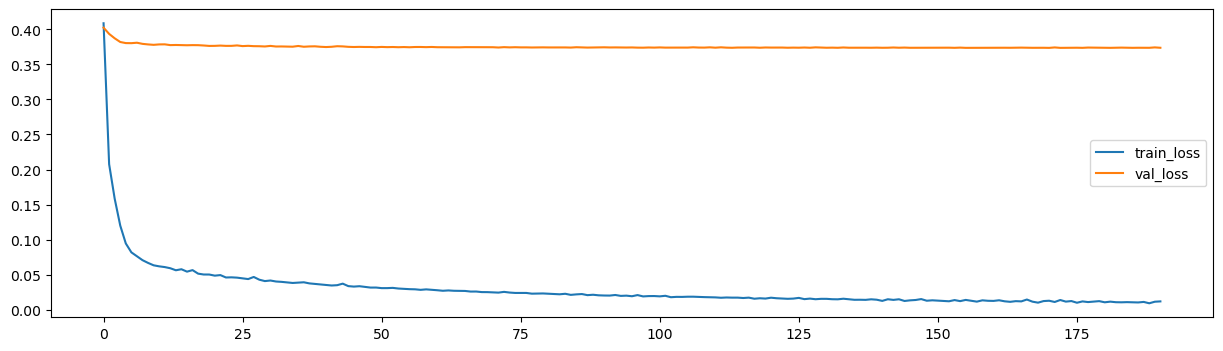

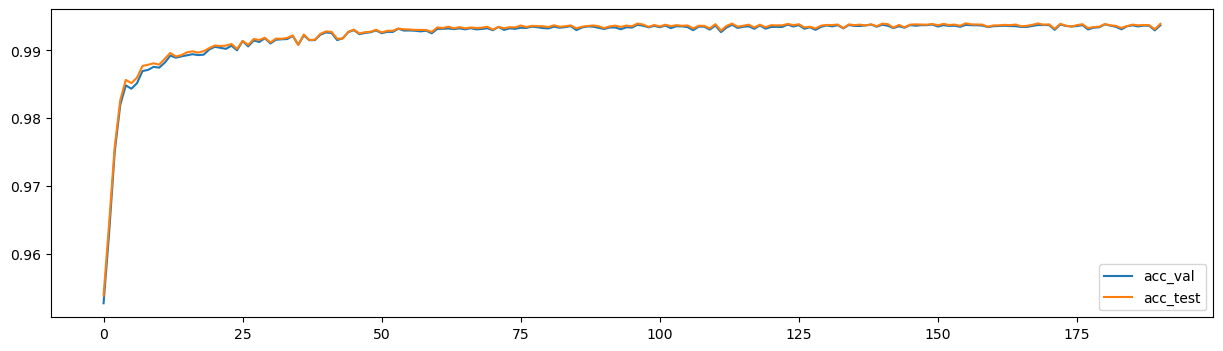

3 100000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.5270 |    0.4150 |   0.9309 |    0.9336 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2872 |    0.3999 |   0.9552 |    0.9562 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2182 |    0.3966 |   0.9611 |    0.9622 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1847 |    0.3922 |   0.9658 |    0.9663 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1675 |    0.3905 |   0.9692 |    0.9699 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.1602 |    0.3912 |   0.9699 |    0.9703


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.1437 |    0.3885 |   0.9729 |    0.9735 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.1398 |    0.3885 |   0.9728 |    0.9738 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.1357 |    0.3875 |   0.9742 |    0.9751 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.1240 |    0.3850 |   0.9773 |    0.9780 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.1119 |    0.3859 |   0.9785 |    0.9789


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.1039 |    0.3825 |   0.9821 |    0.9827 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0974 |    0.3829 |   0.9819 |    0.9822


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0951 |    0.3830 |   0.9816 |    0.9817


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0888 |    0.3807 |   0.9849 |    0.9852 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0876 |    0.3806 |   0.9851 |    0.9854 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0844 |    0.3813 |   0.9837 |    0.9843


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0820 |    0.3807 |   0.9845 |    0.9851


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0825 |    0.3801 |   0.9861 |    0.9865 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0763 |    0.3801 |   0.9857 |    0.9861


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0763 |    0.3797 |   0.9862 |    0.9866 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0746 |    0.3796 |   0.9863 |    0.9866 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0722 |    0.3791 |   0.9873 |    0.9876 *


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0731 |    0.3800 |   0.9856 |    0.9860


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0710 |    0.3793 |   0.9871 |    0.9875


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0692 |    0.3791 |   0.9871 |    0.9875


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0691 |    0.3791 |   0.9876 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0673 |    0.3789 |   0.9874 |    0.9875 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0673 |    0.3781 |   0.9884 |    0.9887 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0662 |    0.3799 |   0.9864 |    0.9867


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0645 |    0.3781 |   0.9887 |    0.9889 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0638 |    0.3780 |   0.9885 |    0.9887 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0632 |    0.3796 |   0.9855 |    0.9855


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0624 |    0.3781 |   0.9886 |    0.9891


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0609 |    0.3782 |   0.9886 |    0.9889


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0608 |    0.3783 |   0.9885 |    0.9887


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0609 |    0.3782 |   0.9884 |    0.9887
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0606 |    0.3781 |   0.9886 |    0.9888
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0585 |    0.3775 |   0.9895 |    0.9897 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0590 |    0.3781 |   0.9885 |    0.9889


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0589 |    0.3779 |   0.9891 |    0.9894


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0573 |    0.3774 |   0.9898 |    0.9901 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0576 |    0.3775 |   0.9890 |    0.9892


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0555 |    0.3776 |   0.9895 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0570 |    0.3780 |   0.9892 |    0.9893


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0551 |    0.3774 |   0.9896 |    0.9898 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0547 |    0.3775 |   0.9896 |    0.9897


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0554 |    0.3773 |   0.9898 |    0.9901 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0543 |    0.3775 |   0.9896 |    0.9897


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0538 |    0.3771 |   0.9904 |    0.9905 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0533 |    0.3769 |   0.9900 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0526 |    0.3768 |   0.9902 |    0.9905 *


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0538 |    0.3774 |   0.9894 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0515 |    0.3772 |   0.9900 |    0.9902


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0519 |    0.3768 |   0.9905 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0508 |    0.3775 |   0.9900 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0509 |    0.3771 |   0.9897 |    0.9900
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0510 |    0.3775 |   0.9896 |    0.9898
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0507 |    0.3766 |   0.9906 |    0.9909 *


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0497 |    0.3768 |   0.9906 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0494 |    0.3768 |   0.9903 |    0.9905


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0491 |    0.3770 |   0.9904 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0487 |    0.3771 |   0.9902 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0488 |    0.3766 |   0.9906 |    0.9908 *


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0482 |    0.3767 |   0.9906 |    0.9907


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0478 |    0.3768 |   0.9907 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0480 |    0.3767 |   0.9904 |    0.9907


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0473 |    0.3765 |   0.9907 |    0.9909 *


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0463 |    0.3763 |   0.9911 |    0.9913 *


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0470 |    0.3765 |   0.9910 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0466 |    0.3764 |   0.9911 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0459 |    0.3763 |   0.9912 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0465 |    0.3766 |   0.9902 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0450 |    0.3766 |   0.9907 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0457 |    0.3764 |   0.9905 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0450 |    0.3762 |   0.9911 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0449 |    0.3765 |   0.9909 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0446 |    0.3762 |   0.9912 |    0.9915 *


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0442 |    0.3761 |   0.9912 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0442 |    0.3764 |   0.9910 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0441 |    0.3764 |   0.9909 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0434 |    0.3767 |   0.9908 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0439 |    0.3760 |   0.9915 |    0.9916 *


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0432 |    0.3764 |   0.9909 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0426 |    0.3760 |   0.9915 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0429 |    0.3760 |   0.9916 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0435 |    0.3762 |   0.9916 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0422 |    0.3762 |   0.9912 |    0.9915
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0427 |    0.3762 |   0.9915 |    0.9917
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0422 |    0.3759 |   0.9913 |    0.9916 *


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0415 |    0.3759 |   0.9918 |    0.9920 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0414 |    0.3760 |   0.9915 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0417 |    0.3760 |   0.9916 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0409 |    0.3760 |   0.9914 |    0.9915


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0413 |    0.3761 |   0.9916 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0415 |    0.3760 |   0.9915 |    0.9918
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0417 |    0.3761 |   0.9910 |    0.9913
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0407 |    0.3757 |   0.9919 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0406 |    0.3761 |   0.9910 |    0.9915


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0391 |    0.3757 |   0.9918 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0415 |    0.3761 |   0.9913 |    0.9916


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0405 |    0.3758 |   0.9918 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0400 |    0.3756 |   0.9917 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0396 |    0.3759 |   0.9913 |    0.9914


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0400 |    0.3757 |   0.9918 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0386 |    0.3759 |   0.9916 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0395 |    0.3758 |   0.9914 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0399 |    0.3756 |   0.9919 |    0.9921
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0385 |    0.3758 |   0.9917 |    0.9920
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0390 |    0.3758 |   0.9918 |    0.9921
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0388 |    0.3754 |   0.9920 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0382 |    0.3757 |   0.9918 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0379 |    0.3756 |   0.9919 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0383 |    0.3758 |   0.9919 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0385 |    0.3758 |   0.9918 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0380 |    0.3756 |   0.9919 |    0.9921
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0373 |    0.3758 |   0.9919 |    0.9922
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0384 |    0.3757 |   0.9919 |    0.9922
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0374 |    0.3756 |   0.9916 |    0.9919
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0374 |    0.3758 |   0.9916 |    0.9919
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0377 |    0.3755 |   0.9920 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0371 |    0.3756 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0369 |    0.3755 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0370 |    0.3754 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0368 |    0.3756 |   0.9921 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0364 |    0.3759 |   0.9916 |    0.9918
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0374 |    0.3754 |   0.9923 |    0.9925 *


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0368 |    0.3754 |   0.9921 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0361 |    0.3754 |   0.9921 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0360 |    0.3757 |   0.9919 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0357 |    0.3755 |   0.9921 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0365 |    0.3753 |   0.9921 |    0.9924 *


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0365 |    0.3755 |   0.9920 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0359 |    0.3756 |   0.9920 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0353 |    0.3760 |   0.9913 |    0.9917


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0361 |    0.3753 |   0.9922 |    0.9925 *


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0363 |    0.3756 |   0.9920 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0355 |    0.3756 |   0.9917 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0354 |    0.3758 |   0.9917 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0353 |    0.3755 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0352 |    0.3754 |   0.9915 |    0.9920
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0349 |    0.3755 |   0.9920 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0348 |    0.3753 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0353 |    0.3754 |   0.9920 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0345 |    0.3754 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0348 |    0.3754 |   0.9922 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0345 |    0.3754 |   0.9920 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0348 |    0.3754 |   0.9922 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0345 |    0.3754 |   0.9921 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0339 |    0.3754 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0339 |    0.3752 |   0.9922 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0365 |    0.3753 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0335 |    0.3757 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0333 |    0.3753 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0345 |    0.3754 |   0.9922 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0340 |    0.3756 |   0.9920 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0349 |    0.3751 |   0.9924 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0344 |    0.3753 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0337 |    0.3754 |   0.9920 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0339 |    0.3752 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0330 |    0.3756 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0333 |    0.3754 |   0.9917 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0341 |    0.3755 |   0.9919 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0331 |    0.3755 |   0.9918 |    0.9920
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0328 |    0.3753 |   0.9922 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0329 |    0.3757 |   0.9914 |    0.9919
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0332 |    0.3755 |   0.9921 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0331 |    0.3751 |   0.9924 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0332 |    0.3753 |   0.9919 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0328 |    0.3751 |   0.9925 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0322 |    0.3751 |   0.9923 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0324 |    0.3753 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0327 |    0.3753 |   0.9922 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0323 |    0.3754 |   0.9922 |    0.9924
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  175 |     0.0322 |    0.3752 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  176 |     0.0322 |    0.3751 |   0.9925 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  177 |     0.0322 |    0.3751 |   0.9924 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  178 |     0.0325 |    0.3764 |   0.9907 |    0.9910
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  179 |     0.0320 |    0.3752 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  180 |     0.0323 |    0.3760 |   0.9909 |    0.9914
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  181 |     0.0329 |    0.3759 |   0.9910 |    0.9913
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  182 |     0.0319 |    0.3751 |   0.9925 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  183 |     0.0321 |    0.3752 |   0.9921 |    0.9923
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  184 |     0.0317 |    0.3751 |   0.9925 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  185 |     0.0316 |    0.3754 |   0.9921 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

  186 |     0.0317 |    0.3755 |   0.9918 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

  187 |     0.0316 |    0.3751 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  188 |     0.0319 |    0.3752 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

  189 |     0.0313 |    0.3753 |   0.9922 |    0.9925
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  190 |     0.0308 |    0.3751 |   0.9926 |    0.9928
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  191 |     0.0320 |    0.3751 |   0.9923 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  192 |     0.0319 |    0.3756 |   0.9913 |    0.9917
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  193 |     0.0311 |    0.3752 |   0.9922 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  194 |     0.0312 |    0.3752 |   0.9924 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  195 |     0.0309 |    0.3751 |   0.9924 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  196 |     0.0318 |    0.3750 |   0.9924 |    0.9927 *


  0%|          | 0/283 [00:00<?, ?it/s]

  197 |     0.0306 |    0.3753 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  198 |     0.0308 |    0.3751 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  199 |     0.0305 |    0.3752 |   0.9924 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

  200 |     0.0309 |    0.3751 |   0.9924 |    0.9929


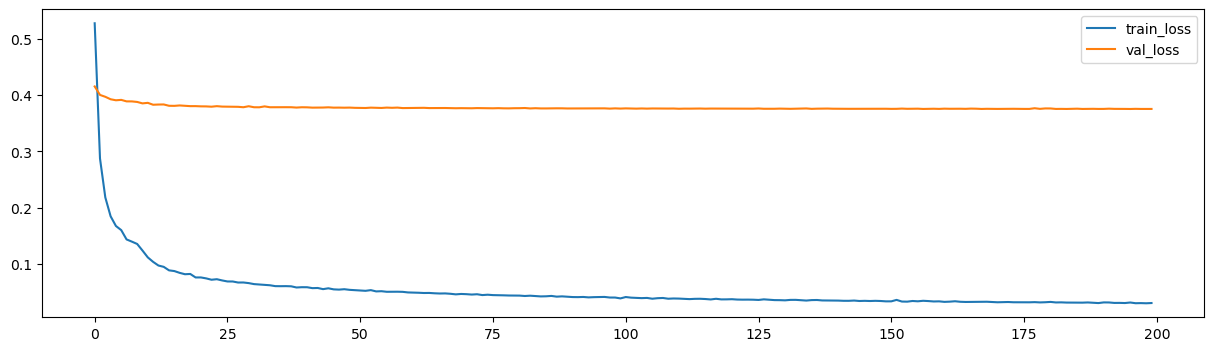

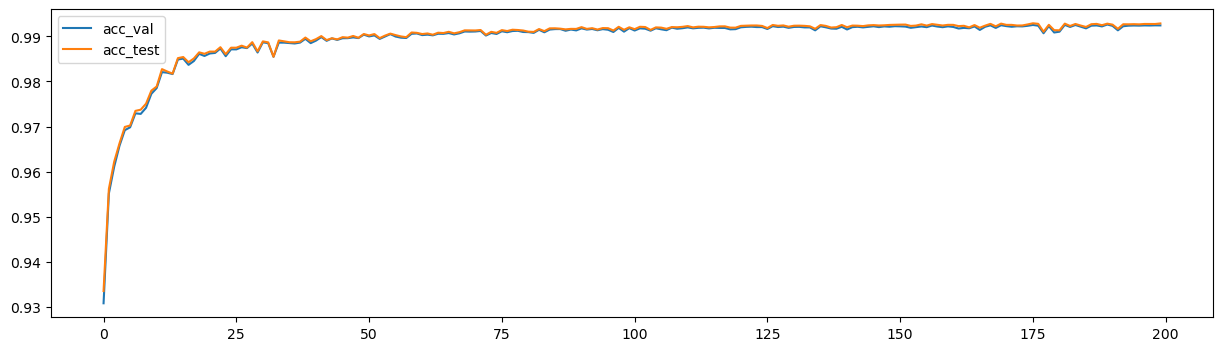

3 500000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4564 |    0.4089 |   0.9415 |    0.9432 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2507 |    0.3987 |   0.9564 |    0.9572 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2035 |    0.3944 |   0.9606 |    0.9618 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1618 |    0.3902 |   0.9703 |    0.9717 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1272 |    0.3850 |   0.9773 |    0.9784 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.1020 |    0.3815 |   0.9828 |    0.9836 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0838 |    0.3801 |   0.9853 |    0.9859 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0785 |    0.3801 |   0.9849 |    0.9857 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0724 |    0.3796 |   0.9859 |    0.9866 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0689 |    0.3787 |   0.9872 |    0.9879 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0676 |    0.3801 |   0.9868 |    0.9874


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0657 |    0.3787 |   0.9874 |    0.9877


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0631 |    0.3783 |   0.9884 |    0.9887 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0615 |    0.3781 |   0.9879 |    0.9886 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0599 |    0.3784 |   0.9880 |    0.9886


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0583 |    0.3779 |   0.9881 |    0.9889 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0578 |    0.3780 |   0.9881 |    0.9888


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0560 |    0.3774 |   0.9890 |    0.9894 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0557 |    0.3779 |   0.9891 |    0.9896


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0523 |    0.3776 |   0.9889 |    0.9895


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0514 |    0.3774 |   0.9889 |    0.9896 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0513 |    0.3766 |   0.9902 |    0.9906 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0510 |    0.3770 |   0.9898 |    0.9902


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0487 |    0.3769 |   0.9899 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0485 |    0.3768 |   0.9904 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0471 |    0.3763 |   0.9909 |    0.9913 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0491 |    0.3770 |   0.9906 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0465 |    0.3766 |   0.9907 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0479 |    0.3764 |   0.9909 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0429 |    0.3766 |   0.9908 |    0.9912


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0438 |    0.3764 |   0.9908 |    0.9913
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0428 |    0.3761 |   0.9912 |    0.9916 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0433 |    0.3760 |   0.9911 |    0.9915 *


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0424 |    0.3764 |   0.9912 |    0.9915


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0414 |    0.3760 |   0.9914 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0407 |    0.3758 |   0.9916 |    0.9921 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0403 |    0.3761 |   0.9915 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0404 |    0.3771 |   0.9899 |    0.9905


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0403 |    0.3756 |   0.9916 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0384 |    0.3758 |   0.9916 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0386 |    0.3755 |   0.9918 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0371 |    0.3757 |   0.9917 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0380 |    0.3755 |   0.9920 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0373 |    0.3759 |   0.9917 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0369 |    0.3758 |   0.9920 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0361 |    0.3751 |   0.9926 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0362 |    0.3759 |   0.9914 |    0.9916


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0357 |    0.3754 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0347 |    0.3752 |   0.9925 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0346 |    0.3754 |   0.9923 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0340 |    0.3753 |   0.9923 |    0.9925
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0336 |    0.3757 |   0.9920 |    0.9922
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0333 |    0.3754 |   0.9921 |    0.9925
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0331 |    0.3751 |   0.9924 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0327 |    0.3753 |   0.9924 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0323 |    0.3755 |   0.9923 |    0.9924


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0323 |    0.3749 |   0.9928 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0312 |    0.3754 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0311 |    0.3748 |   0.9927 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0313 |    0.3750 |   0.9928 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0303 |    0.3753 |   0.9923 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0307 |    0.3749 |   0.9926 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0307 |    0.3746 |   0.9931 |    0.9932 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0298 |    0.3750 |   0.9926 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0301 |    0.3748 |   0.9928 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0293 |    0.3747 |   0.9931 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0290 |    0.3748 |   0.9930 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0285 |    0.3746 |   0.9931 |    0.9933 *


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0290 |    0.3747 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0285 |    0.3750 |   0.9928 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0278 |    0.3747 |   0.9930 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0277 |    0.3748 |   0.9931 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0277 |    0.3753 |   0.9923 |    0.9923
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0275 |    0.3746 |   0.9931 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0270 |    0.3747 |   0.9931 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0265 |    0.3746 |   0.9932 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0272 |    0.3749 |   0.9925 |    0.9927
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0270 |    0.3746 |   0.9930 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0272 |    0.3745 |   0.9932 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0253 |    0.3746 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0257 |    0.3745 |   0.9933 |    0.9936 *


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0260 |    0.3748 |   0.9929 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0257 |    0.3745 |   0.9932 |    0.9933 *


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0244 |    0.3746 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0249 |    0.3744 |   0.9931 |    0.9933 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0265 |    0.3745 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0249 |    0.3746 |   0.9929 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0240 |    0.3747 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0245 |    0.3749 |   0.9928 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0236 |    0.3744 |   0.9933 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0236 |    0.3745 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0244 |    0.3747 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0237 |    0.3743 |   0.9934 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0237 |    0.3745 |   0.9932 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0232 |    0.3742 |   0.9933 |    0.9934 *


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0223 |    0.3743 |   0.9933 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0228 |    0.3744 |   0.9933 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0237 |    0.3745 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0220 |    0.3744 |   0.9932 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0226 |    0.3745 |   0.9930 |    0.9931
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0222 |    0.3742 |   0.9936 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0216 |    0.3747 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0227 |    0.3744 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0217 |    0.3744 |   0.9932 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0214 |    0.3744 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0209 |    0.3745 |   0.9931 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0219 |    0.3742 |   0.9934 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0218 |    0.3743 |   0.9934 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0208 |    0.3744 |   0.9931 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0211 |    0.3744 |   0.9933 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0203 |    0.3745 |   0.9932 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0209 |    0.3743 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0205 |    0.3742 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0197 |    0.3741 |   0.9935 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0196 |    0.3742 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0195 |    0.3745 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0203 |    0.3742 |   0.9934 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0204 |    0.3744 |   0.9932 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0199 |    0.3743 |   0.9933 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0194 |    0.3741 |   0.9935 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0189 |    0.3742 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0194 |    0.3742 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0191 |    0.3742 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0190 |    0.3743 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0202 |    0.3744 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0189 |    0.3743 |   0.9933 |    0.9933
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0184 |    0.3741 |   0.9934 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0185 |    0.3745 |   0.9930 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0185 |    0.3744 |   0.9933 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0185 |    0.3743 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0189 |    0.3742 |   0.9935 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0175 |    0.3741 |   0.9936 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0181 |    0.3742 |   0.9933 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0171 |    0.3742 |   0.9935 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0179 |    0.3742 |   0.9934 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0172 |    0.3740 |   0.9934 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0177 |    0.3742 |   0.9933 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0177 |    0.3742 |   0.9933 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0182 |    0.3744 |   0.9929 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0181 |    0.3742 |   0.9934 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0163 |    0.3741 |   0.9933 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0168 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0167 |    0.3742 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0169 |    0.3742 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0169 |    0.3742 |   0.9935 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0163 |    0.3741 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0170 |    0.3741 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0157 |    0.3741 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0156 |    0.3741 |   0.9933 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0173 |    0.3742 |   0.9933 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0166 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0151 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0168 |    0.3741 |   0.9935 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0160 |    0.3743 |   0.9931 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0160 |    0.3742 |   0.9934 |    0.9935
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0167 |    0.3741 |   0.9934 |    0.9934
Early stopping at epoch 156


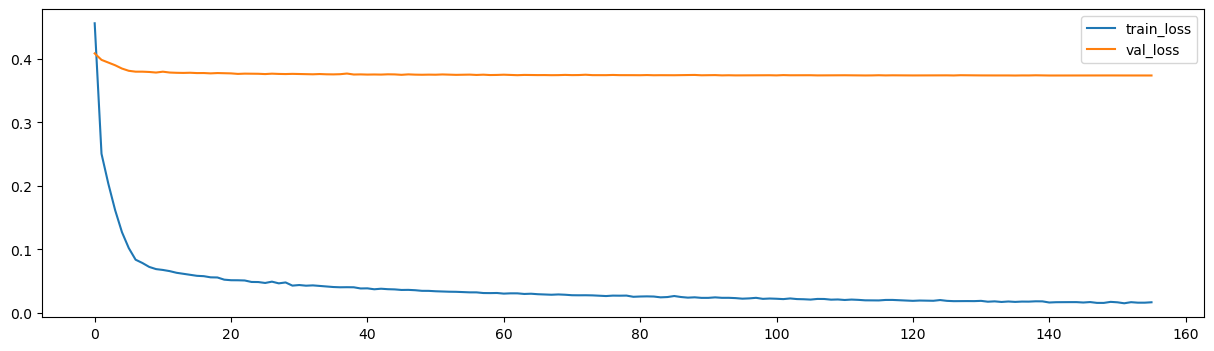

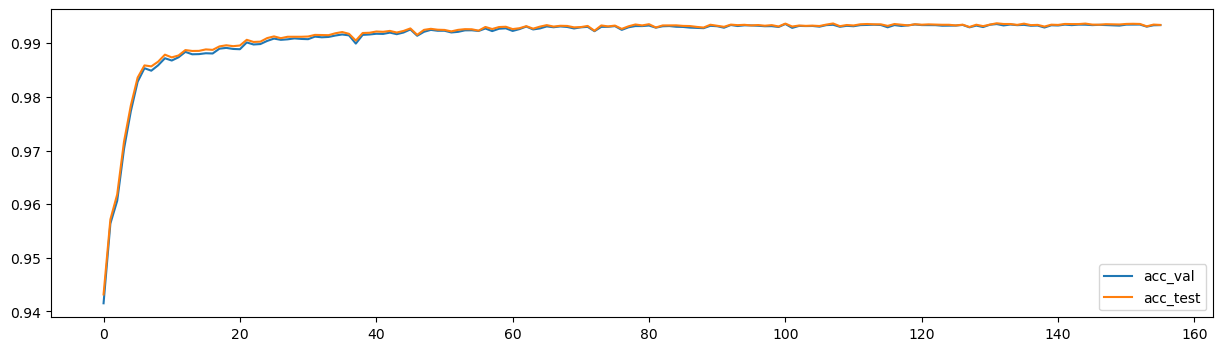

  0%|          | 0/3 [00:00<?, ?it/s]

4 1000000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4797 |    0.4070 |   0.9418 |    0.9438 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2517 |    0.3974 |   0.9647 |    0.9659 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.1439 |    0.3837 |   0.9803 |    0.9814 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.0934 |    0.3813 |   0.9830 |    0.9837 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.0821 |    0.3794 |   0.9861 |    0.9869 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.0726 |    0.3794 |   0.9874 |    0.9882 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0684 |    0.3785 |   0.9875 |    0.9885 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0624 |    0.3784 |   0.9885 |    0.9890 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0595 |    0.3771 |   0.9896 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0576 |    0.3776 |   0.9892 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0548 |    0.3773 |   0.9897 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0512 |    0.3766 |   0.9905 |    0.9910 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0499 |    0.3769 |   0.9905 |    0.9910


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0472 |    0.3763 |   0.9911 |    0.9914 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0459 |    0.3769 |   0.9903 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0507 |    0.3764 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0436 |    0.3757 |   0.9918 |    0.9922 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0418 |    0.3760 |   0.9918 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0407 |    0.3757 |   0.9921 |    0.9926 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0448 |    0.3761 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0398 |    0.3754 |   0.9919 |    0.9925 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0399 |    0.3756 |   0.9920 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0385 |    0.3757 |   0.9917 |    0.9921


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0380 |    0.3760 |   0.9919 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0370 |    0.3757 |   0.9922 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0360 |    0.3753 |   0.9923 |    0.9924 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0358 |    0.3754 |   0.9923 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0359 |    0.3755 |   0.9923 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0345 |    0.3753 |   0.9925 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0343 |    0.3750 |   0.9930 |    0.9934 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0333 |    0.3747 |   0.9930 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0332 |    0.3750 |   0.9928 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0337 |    0.3751 |   0.9926 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0322 |    0.3747 |   0.9934 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0325 |    0.3752 |   0.9930 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0319 |    0.3747 |   0.9932 |    0.9936
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0321 |    0.3751 |   0.9930 |    0.9933
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0311 |    0.3748 |   0.9936 |    0.9938
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0296 |    0.3747 |   0.9931 |    0.9935
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0295 |    0.3745 |   0.9937 |    0.9940 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0306 |    0.3754 |   0.9929 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0294 |    0.3744 |   0.9936 |    0.9939 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0279 |    0.3749 |   0.9931 |    0.9934


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0284 |    0.3743 |   0.9936 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0278 |    0.3743 |   0.9937 |    0.9940 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0270 |    0.3745 |   0.9935 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0281 |    0.3743 |   0.9935 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0263 |    0.3744 |   0.9933 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0276 |    0.3744 |   0.9935 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0266 |    0.3744 |   0.9939 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0254 |    0.3742 |   0.9940 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0269 |    0.3745 |   0.9937 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0250 |    0.3741 |   0.9940 |    0.9941 *


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0248 |    0.3743 |   0.9938 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0248 |    0.3740 |   0.9940 |    0.9942 *


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0240 |    0.3742 |   0.9937 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0238 |    0.3744 |   0.9937 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0239 |    0.3743 |   0.9935 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0240 |    0.3742 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0226 |    0.3741 |   0.9940 |    0.9944
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0248 |    0.3742 |   0.9939 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0222 |    0.3741 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0223 |    0.3738 |   0.9940 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0221 |    0.3740 |   0.9939 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0220 |    0.3741 |   0.9939 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0220 |    0.3745 |   0.9932 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0218 |    0.3741 |   0.9941 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0215 |    0.3740 |   0.9940 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0207 |    0.3740 |   0.9940 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0209 |    0.3743 |   0.9937 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0211 |    0.3740 |   0.9941 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0211 |    0.3740 |   0.9941 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0199 |    0.3739 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0196 |    0.3739 |   0.9939 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0203 |    0.3737 |   0.9943 |    0.9946 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0198 |    0.3739 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0188 |    0.3741 |   0.9938 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0192 |    0.3738 |   0.9943 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0187 |    0.3742 |   0.9939 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0188 |    0.3738 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0180 |    0.3739 |   0.9938 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0179 |    0.3740 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0184 |    0.3740 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0184 |    0.3741 |   0.9938 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0189 |    0.3738 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0174 |    0.3740 |   0.9939 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0171 |    0.3738 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0176 |    0.3738 |   0.9942 |    0.9946
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0169 |    0.3738 |   0.9941 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0171 |    0.3739 |   0.9940 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0166 |    0.3737 |   0.9942 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0169 |    0.3741 |   0.9940 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0158 |    0.3738 |   0.9941 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0162 |    0.3738 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0168 |    0.3737 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0156 |    0.3740 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0151 |    0.3736 |   0.9942 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0161 |    0.3737 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0159 |    0.3738 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0165 |    0.3737 |   0.9941 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0156 |    0.3739 |   0.9941 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0142 |    0.3738 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0155 |    0.3738 |   0.9943 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0148 |    0.3737 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0144 |    0.3737 |   0.9943 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0152 |    0.3740 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0138 |    0.3736 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0146 |    0.3738 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0162 |    0.3738 |   0.9941 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0141 |    0.3736 |   0.9944 |    0.9947
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0136 |    0.3737 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0147 |    0.3735 |   0.9943 |    0.9946 *


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0135 |    0.3737 |   0.9941 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0132 |    0.3737 |   0.9941 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0129 |    0.3740 |   0.9937 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0134 |    0.3737 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0137 |    0.3738 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0139 |    0.3739 |   0.9941 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0137 |    0.3738 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0128 |    0.3737 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0130 |    0.3738 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0122 |    0.3737 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0117 |    0.3736 |   0.9944 |    0.9947
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0133 |    0.3736 |   0.9943 |    0.9946
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0138 |    0.3739 |   0.9940 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0123 |    0.3735 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0119 |    0.3737 |   0.9941 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0123 |    0.3740 |   0.9939 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0126 |    0.3735 |   0.9943 |    0.9946 *


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0132 |    0.3735 |   0.9943 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0118 |    0.3736 |   0.9943 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0112 |    0.3736 |   0.9943 |    0.9946


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0123 |    0.3736 |   0.9942 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0106 |    0.3737 |   0.9941 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0107 |    0.3737 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0110 |    0.3737 |   0.9941 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0112 |    0.3737 |   0.9939 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0117 |    0.3737 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0126 |    0.3738 |   0.9940 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0114 |    0.3735 |   0.9943 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0112 |    0.3735 |   0.9944 |    0.9946 *


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0103 |    0.3738 |   0.9941 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0102 |    0.3735 |   0.9942 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0116 |    0.3737 |   0.9941 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0111 |    0.3739 |   0.9939 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0108 |    0.3736 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0111 |    0.3737 |   0.9939 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0106 |    0.3735 |   0.9943 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0105 |    0.3735 |   0.9944 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0097 |    0.3736 |   0.9943 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0105 |    0.3737 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0104 |    0.3738 |   0.9939 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0107 |    0.3734 |   0.9945 |    0.9947 *


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0091 |    0.3733 |   0.9945 |    0.9948 *


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0091 |    0.3736 |   0.9942 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0099 |    0.3737 |   0.9941 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0104 |    0.3737 |   0.9940 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0100 |    0.3737 |   0.9940 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0092 |    0.3735 |   0.9944 |    0.9947
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0089 |    0.3737 |   0.9940 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  161 |     0.0107 |    0.3735 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  162 |     0.0106 |    0.3737 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  163 |     0.0100 |    0.3738 |   0.9939 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  164 |     0.0087 |    0.3734 |   0.9945 |    0.9947
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  165 |     0.0089 |    0.3737 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  166 |     0.0100 |    0.3736 |   0.9941 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  167 |     0.0093 |    0.3734 |   0.9944 |    0.9947
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  168 |     0.0080 |    0.3735 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  169 |     0.0094 |    0.3734 |   0.9944 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  170 |     0.0093 |    0.3737 |   0.9938 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  171 |     0.0090 |    0.3736 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  172 |     0.0080 |    0.3734 |   0.9944 |    0.9947
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  173 |     0.0089 |    0.3737 |   0.9940 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  174 |     0.0098 |    0.3735 |   0.9943 |    0.9946
Early stopping at epoch 174


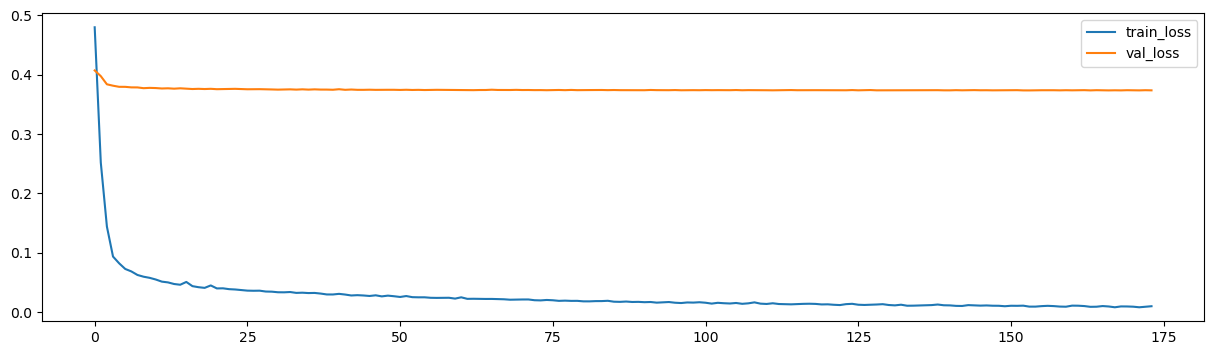

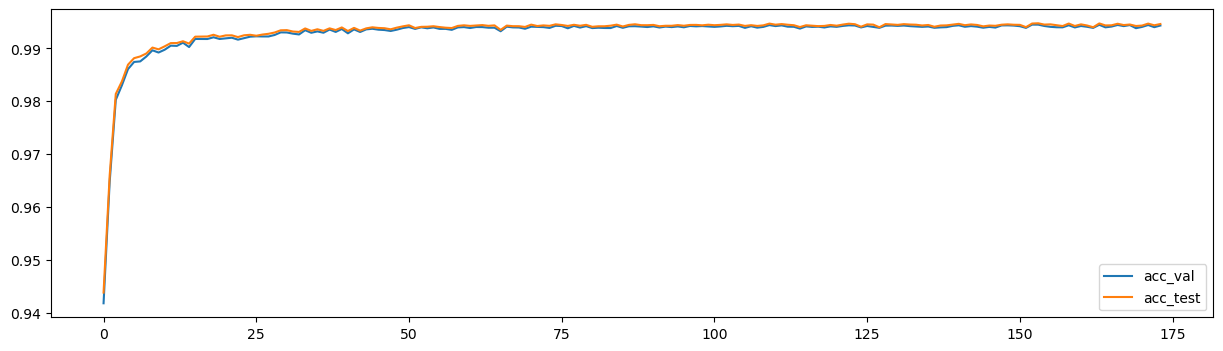

4 100000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.5365 |    0.4125 |   0.9349 |    0.9367 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2965 |    0.4040 |   0.9473 |    0.9487 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2449 |    0.4022 |   0.9545 |    0.9552 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.2106 |    0.3955 |   0.9618 |    0.9626 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.1775 |    0.3923 |   0.9651 |    0.9661 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.1616 |    0.3921 |   0.9686 |    0.9696 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.1491 |    0.3884 |   0.9712 |    0.9722 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.1348 |    0.3886 |   0.9717 |    0.9725


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.1165 |    0.3841 |   0.9791 |    0.9801 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0969 |    0.3815 |   0.9833 |    0.9842 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0844 |    0.3800 |   0.9852 |    0.9860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0793 |    0.3798 |   0.9861 |    0.9869 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0728 |    0.3793 |   0.9868 |    0.9876 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0697 |    0.3788 |   0.9871 |    0.9880 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0710 |    0.3793 |   0.9865 |    0.9873


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0662 |    0.3783 |   0.9874 |    0.9881 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0638 |    0.3786 |   0.9877 |    0.9885


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0619 |    0.3782 |   0.9879 |    0.9887 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0612 |    0.3778 |   0.9884 |    0.9891 *


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0601 |    0.3777 |   0.9885 |    0.9892 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0587 |    0.3779 |   0.9887 |    0.9893


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0581 |    0.3777 |   0.9886 |    0.9892 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0583 |    0.3781 |   0.9887 |    0.9894


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0551 |    0.3776 |   0.9890 |    0.9898 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0555 |    0.3789 |   0.9867 |    0.9875


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0543 |    0.3774 |   0.9892 |    0.9897 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0525 |    0.3771 |   0.9897 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0516 |    0.3772 |   0.9898 |    0.9903


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0523 |    0.3769 |   0.9897 |    0.9902 *


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0508 |    0.3769 |   0.9902 |    0.9906 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0496 |    0.3769 |   0.9902 |    0.9908


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0489 |    0.3772 |   0.9899 |    0.9904


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0484 |    0.3766 |   0.9903 |    0.9909 *


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0479 |    0.3771 |   0.9906 |    0.9909


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0464 |    0.3766 |   0.9901 |    0.9905 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0458 |    0.3769 |   0.9903 |    0.9906


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0462 |    0.3766 |   0.9906 |    0.9911


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0451 |    0.3766 |   0.9909 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0440 |    0.3762 |   0.9910 |    0.9915 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0437 |    0.3761 |   0.9913 |    0.9918 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0425 |    0.3761 |   0.9914 |    0.9919


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0418 |    0.3761 |   0.9913 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0418 |    0.3758 |   0.9915 |    0.9919 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0412 |    0.3762 |   0.9913 |    0.9918


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0416 |    0.3759 |   0.9916 |    0.9920


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0401 |    0.3757 |   0.9918 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0404 |    0.3757 |   0.9919 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0391 |    0.3755 |   0.9919 |    0.9923 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0389 |    0.3753 |   0.9920 |    0.9924 *


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0386 |    0.3755 |   0.9921 |    0.9926


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0384 |    0.3750 |   0.9925 |    0.9929 *


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0377 |    0.3755 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0373 |    0.3758 |   0.9918 |    0.9922


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0364 |    0.3748 |   0.9928 |    0.9930 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0365 |    0.3750 |   0.9927 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0356 |    0.3756 |   0.9923 |    0.9927


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0360 |    0.3751 |   0.9924 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0348 |    0.3750 |   0.9927 |    0.9931


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0344 |    0.3750 |   0.9928 |    0.9932
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0342 |    0.3755 |   0.9927 |    0.9930
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0339 |    0.3750 |   0.9928 |    0.9933
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0334 |    0.3750 |   0.9929 |    0.9933
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0335 |    0.3750 |   0.9927 |    0.9931
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0332 |    0.3746 |   0.9931 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0326 |    0.3747 |   0.9929 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0328 |    0.3748 |   0.9930 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0319 |    0.3754 |   0.9926 |    0.9928


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0316 |    0.3749 |   0.9928 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0313 |    0.3748 |   0.9928 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0317 |    0.3756 |   0.9924 |    0.9926
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0309 |    0.3752 |   0.9926 |    0.9930
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0307 |    0.3748 |   0.9931 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0311 |    0.3750 |   0.9931 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0303 |    0.3750 |   0.9930 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0307 |    0.3746 |   0.9931 |    0.9933 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0306 |    0.3746 |   0.9935 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0293 |    0.3750 |   0.9932 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0297 |    0.3745 |   0.9935 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0292 |    0.3747 |   0.9932 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0294 |    0.3746 |   0.9930 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0295 |    0.3748 |   0.9930 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0294 |    0.3745 |   0.9935 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0289 |    0.3747 |   0.9934 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0282 |    0.3746 |   0.9935 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0280 |    0.3745 |   0.9935 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0280 |    0.3748 |   0.9932 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0282 |    0.3746 |   0.9935 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0276 |    0.3744 |   0.9932 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0281 |    0.3745 |   0.9934 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0271 |    0.3747 |   0.9934 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0276 |    0.3742 |   0.9937 |    0.9939 *


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0269 |    0.3745 |   0.9937 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0274 |    0.3743 |   0.9937 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0270 |    0.3743 |   0.9935 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0264 |    0.3744 |   0.9936 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0265 |    0.3744 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0269 |    0.3742 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0264 |    0.3745 |   0.9934 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0265 |    0.3745 |   0.9934 |    0.9937
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0259 |    0.3744 |   0.9937 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0257 |    0.3745 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0257 |    0.3743 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0256 |    0.3743 |   0.9936 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0254 |    0.3742 |   0.9936 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0255 |    0.3745 |   0.9934 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0254 |    0.3742 |   0.9939 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0252 |    0.3744 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0246 |    0.3743 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0251 |    0.3742 |   0.9938 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0244 |    0.3742 |   0.9940 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0247 |    0.3744 |   0.9935 |    0.9938
Early stopping at epoch 111


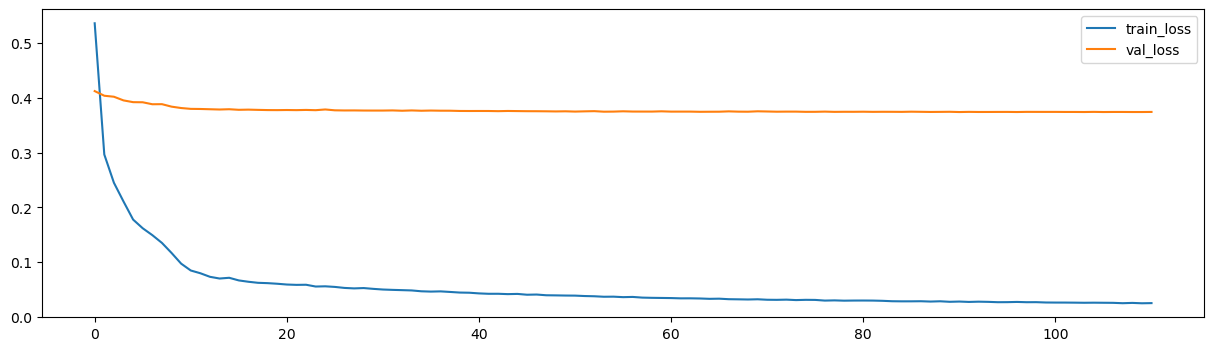

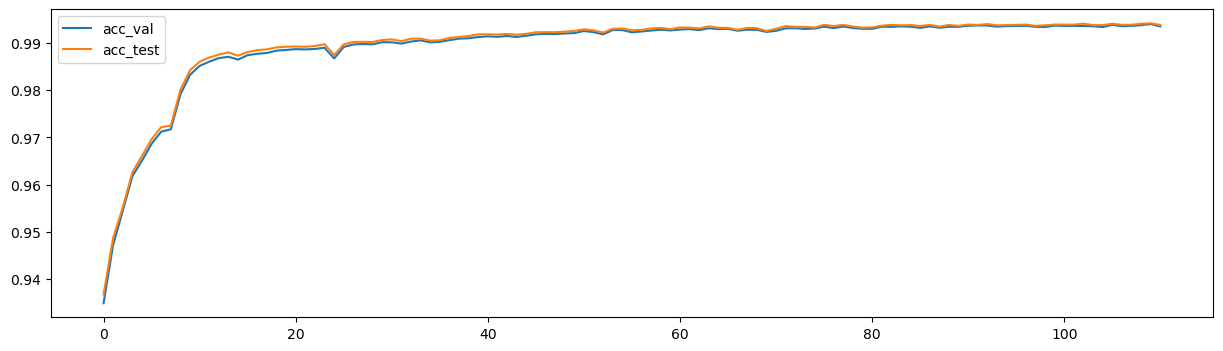

4 500000
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.4894 |    0.4091 |   0.9415 |    0.9436 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.2695 |    0.4014 |   0.9524 |    0.9535 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.2075 |    0.3943 |   0.9641 |    0.9653 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.1415 |    0.3854 |   0.9775 |    0.9785 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.0957 |    0.3817 |   0.9835 |    0.9843 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.0782 |    0.3788 |   0.9869 |    0.9876 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.0670 |    0.3791 |   0.9880 |    0.9888


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.0626 |    0.3782 |   0.9882 |    0.9889 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.0575 |    0.3771 |   0.9897 |    0.9904 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.0545 |    0.3770 |   0.9899 |    0.9907 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.0522 |    0.3772 |   0.9893 |    0.9901


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.0508 |    0.3770 |   0.9904 |    0.9911 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.0476 |    0.3760 |   0.9911 |    0.9917 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.0469 |    0.3762 |   0.9908 |    0.9913


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.0456 |    0.3757 |   0.9918 |    0.9924 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.0488 |    0.3777 |   0.9891 |    0.9898


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.0435 |    0.3757 |   0.9914 |    0.9920 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.0416 |    0.3758 |   0.9917 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.0415 |    0.3759 |   0.9918 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.0410 |    0.3758 |   0.9921 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.0408 |    0.3751 |   0.9922 |    0.9928 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.0404 |    0.3752 |   0.9923 |    0.9925


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.0381 |    0.3754 |   0.9925 |    0.9929


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.0384 |    0.3758 |   0.9919 |    0.9923


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.0381 |    0.3754 |   0.9926 |    0.9930


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.0380 |    0.3758 |   0.9914 |    0.9918
LR reduction to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.0375 |    0.3754 |   0.9925 |    0.9929
LR reduction to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.0374 |    0.3751 |   0.9928 |    0.9933
LR reduction to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.0356 |    0.3752 |   0.9926 |    0.9931
LR reduction to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.0347 |    0.3752 |   0.9925 |    0.9929
LR reduction to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.0344 |    0.3755 |   0.9923 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.0347 |    0.3754 |   0.9924 |    0.9929
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.0335 |    0.3752 |   0.9927 |    0.9932
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.0331 |    0.3750 |   0.9930 |    0.9935 *


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.0327 |    0.3750 |   0.9930 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.0326 |    0.3749 |   0.9933 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.0323 |    0.3747 |   0.9932 |    0.9936 *


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.0324 |    0.3749 |   0.9931 |    0.9935


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.0318 |    0.3748 |   0.9930 |    0.9933


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.0304 |    0.3747 |   0.9933 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.0299 |    0.3746 |   0.9934 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.0298 |    0.3746 |   0.9934 |    0.9937 *


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.0297 |    0.3749 |   0.9933 |    0.9936


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.0305 |    0.3746 |   0.9935 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.0293 |    0.3746 |   0.9934 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.0293 |    0.3748 |   0.9936 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.0284 |    0.3747 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.0287 |    0.3744 |   0.9935 |    0.9938 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.0276 |    0.3745 |   0.9935 |    0.9938


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.0275 |    0.3742 |   0.9938 |    0.9941 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.0265 |    0.3746 |   0.9935 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.0267 |    0.3745 |   0.9933 |    0.9937


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.0271 |    0.3747 |   0.9926 |    0.9932


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.0264 |    0.3741 |   0.9938 |    0.9941 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.0270 |    0.3743 |   0.9939 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.0255 |    0.3743 |   0.9937 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.0253 |    0.3744 |   0.9935 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.0254 |    0.3743 |   0.9937 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.0251 |    0.3742 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.0251 |    0.3746 |   0.9936 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.0246 |    0.3742 |   0.9935 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.0248 |    0.3742 |   0.9937 |    0.9939
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.0243 |    0.3743 |   0.9939 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.0237 |    0.3743 |   0.9935 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.0242 |    0.3742 |   0.9937 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.0232 |    0.3749 |   0.9930 |    0.9934
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.0234 |    0.3742 |   0.9939 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.0232 |    0.3742 |   0.9938 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.0229 |    0.3741 |   0.9939 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.0235 |    0.3741 |   0.9939 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.0215 |    0.3742 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.0225 |    0.3741 |   0.9937 |    0.9941 *


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.0221 |    0.3739 |   0.9939 |    0.9942 *


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.0223 |    0.3741 |   0.9939 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.0214 |    0.3740 |   0.9938 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.0209 |    0.3742 |   0.9936 |    0.9939


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.0209 |    0.3739 |   0.9940 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.0216 |    0.3741 |   0.9937 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.0210 |    0.3740 |   0.9939 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.0204 |    0.3739 |   0.9938 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.0208 |    0.3743 |   0.9936 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.0206 |    0.3740 |   0.9939 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.0206 |    0.3739 |   0.9940 |    0.9943 *


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.0202 |    0.3741 |   0.9939 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.0194 |    0.3739 |   0.9935 |    0.9939 *


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.0193 |    0.3742 |   0.9938 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.0193 |    0.3740 |   0.9939 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.0192 |    0.3738 |   0.9940 |    0.9942 *


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.0192 |    0.3740 |   0.9937 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.0193 |    0.3740 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.0196 |    0.3739 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.0198 |    0.3741 |   0.9937 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.0184 |    0.3739 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.0178 |    0.3739 |   0.9940 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.0180 |    0.3738 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.0175 |    0.3739 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.0173 |    0.3738 |   0.9942 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.0185 |    0.3740 |   0.9939 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.0179 |    0.3738 |   0.9941 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.0172 |    0.3739 |   0.9938 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  101 |     0.0180 |    0.3739 |   0.9939 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  102 |     0.0179 |    0.3743 |   0.9935 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  103 |     0.0169 |    0.3739 |   0.9937 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  104 |     0.0174 |    0.3740 |   0.9938 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  105 |     0.0170 |    0.3740 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  106 |     0.0160 |    0.3741 |   0.9938 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  107 |     0.0166 |    0.3739 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  108 |     0.0165 |    0.3742 |   0.9933 |    0.9936
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  109 |     0.0164 |    0.3737 |   0.9941 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

  110 |     0.0159 |    0.3739 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  111 |     0.0162 |    0.3740 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  112 |     0.0157 |    0.3739 |   0.9940 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  113 |     0.0168 |    0.3739 |   0.9940 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  114 |     0.0170 |    0.3738 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  115 |     0.0155 |    0.3741 |   0.9937 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  116 |     0.0156 |    0.3738 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  117 |     0.0166 |    0.3738 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  118 |     0.0163 |    0.3741 |   0.9936 |    0.9940
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  119 |     0.0160 |    0.3738 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  120 |     0.0147 |    0.3737 |   0.9940 |    0.9943 *


  0%|          | 0/283 [00:00<?, ?it/s]

  121 |     0.0161 |    0.3739 |   0.9938 |    0.9941


  0%|          | 0/283 [00:00<?, ?it/s]

  122 |     0.0158 |    0.3738 |   0.9942 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  123 |     0.0151 |    0.3739 |   0.9938 |    0.9940


  0%|          | 0/283 [00:00<?, ?it/s]

  124 |     0.0146 |    0.3736 |   0.9942 |    0.9945 *


  0%|          | 0/283 [00:00<?, ?it/s]

  125 |     0.0141 |    0.3737 |   0.9941 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  126 |     0.0146 |    0.3738 |   0.9941 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  127 |     0.0150 |    0.3739 |   0.9939 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  128 |     0.0141 |    0.3740 |   0.9939 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  129 |     0.0151 |    0.3740 |   0.9939 |    0.9941
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  130 |     0.0150 |    0.3737 |   0.9940 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  131 |     0.0142 |    0.3738 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  132 |     0.0145 |    0.3738 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  133 |     0.0133 |    0.3738 |   0.9939 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  134 |     0.0139 |    0.3737 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  135 |     0.0132 |    0.3739 |   0.9937 |    0.9938
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  136 |     0.0145 |    0.3736 |   0.9942 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

  137 |     0.0133 |    0.3736 |   0.9941 |    0.9943 *


  0%|          | 0/283 [00:00<?, ?it/s]

  138 |     0.0144 |    0.3738 |   0.9941 |    0.9943


  0%|          | 0/283 [00:00<?, ?it/s]

  139 |     0.0143 |    0.3737 |   0.9941 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  140 |     0.0131 |    0.3736 |   0.9942 |    0.9944 *


  0%|          | 0/283 [00:00<?, ?it/s]

  141 |     0.0138 |    0.3737 |   0.9942 |    0.9944


  0%|          | 0/283 [00:00<?, ?it/s]

  142 |     0.0128 |    0.3737 |   0.9941 |    0.9945


  0%|          | 0/283 [00:00<?, ?it/s]

  143 |     0.0138 |    0.3738 |   0.9940 |    0.9942


  0%|          | 0/283 [00:00<?, ?it/s]

  144 |     0.0135 |    0.3736 |   0.9943 |    0.9946


  0%|          | 0/283 [00:00<?, ?it/s]

  145 |     0.0123 |    0.3738 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  146 |     0.0140 |    0.3736 |   0.9943 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  147 |     0.0116 |    0.3736 |   0.9941 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  148 |     0.0127 |    0.3737 |   0.9941 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  149 |     0.0135 |    0.3736 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  150 |     0.0127 |    0.3737 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  151 |     0.0122 |    0.3737 |   0.9940 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  152 |     0.0150 |    0.3738 |   0.9940 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  153 |     0.0121 |    0.3737 |   0.9941 |    0.9942
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  154 |     0.0113 |    0.3736 |   0.9942 |    0.9945
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  155 |     0.0121 |    0.3737 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  156 |     0.0126 |    0.3737 |   0.9940 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  157 |     0.0118 |    0.3737 |   0.9941 |    0.9943
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  158 |     0.0128 |    0.3736 |   0.9942 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  159 |     0.0111 |    0.3737 |   0.9941 |    0.9944
LR reduction to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

  160 |     0.0127 |    0.3737 |   0.9942 |    0.9943
Early stopping at epoch 160


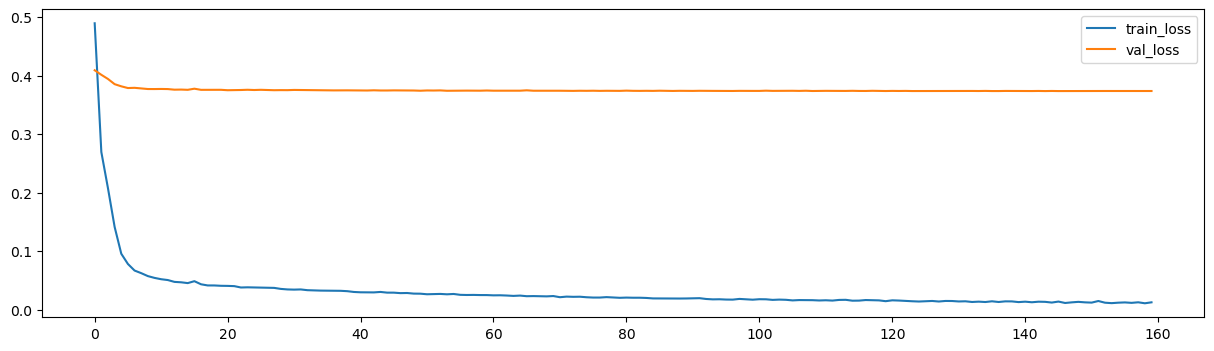

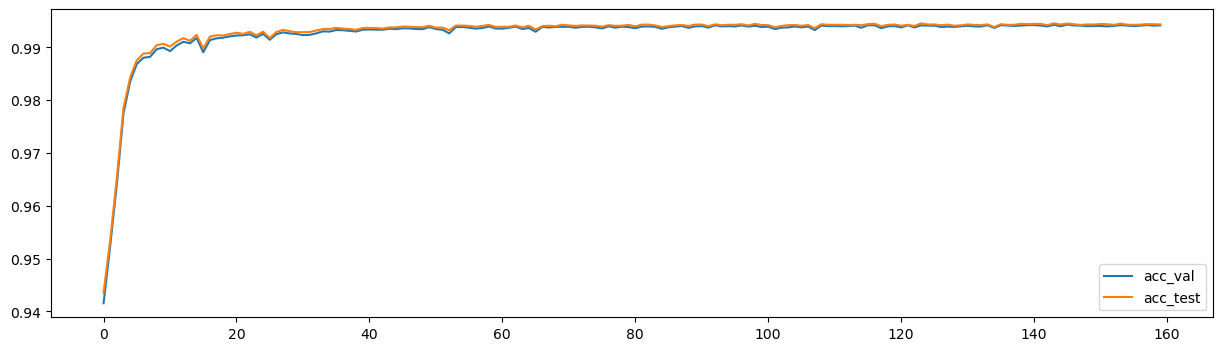

[None, None, None, None, None, None, None, None, None]

In [6]:
def f(n_layers,target_params):
    gc.collect()
    torch.cuda.empty_cache()
    print(n_layers, target_params)
    # Find out the hyperparameteres yielding #params = target_params
    def objective(h):
        return count_parameters(InteractionNetwork(int(h),n_layers)) - target_params
    optimal_h = int(root_scalar(objective, bracket=[1, 50000], method='bisect').root)
    optimal_h= pd.Series({optimal_h:target_params-count_parameters(InteractionNetwork(optimal_h, n_layers)),
                optimal_h-1:target_params-count_parameters(InteractionNetwork(optimal_h-1,n_layers)),
                optimal_h+1:target_params-count_parameters(InteractionNetwork(optimal_h+1,n_layers))}).abs().idxmin()
    
    model = InteractionNetwork(optimal_h,n_layers).to(device)
    lr = LR
    optimizer = optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')
    epochs_no_improve, epochs_no_improve2 = 0,0
    best_model_state = None
    stats = []
    best = None
    # Print header once
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
    print("-" * 50)
    for epoch in trange(MAX_EPOCHS):
        train_loss = train_epoch(model, loader_train, optimizer)   
        preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
        preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
        
        stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
        if val_loss < best_val_loss: 
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
            best_val_loss = val_loss
            epochs_no_improve = 0
            epochs_no_improve2 = 0
            best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                    'preds_test':preds_test, 'preds_val':preds_val}        
        else:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
            epochs_no_improve += 1
            epochs_no_improve2 += 1
    
        if epochs_no_improve >= TOLERANCE:
            print(f"Early stopping at epoch {epoch+1}")
            break
        if epochs_no_improve2 >= LR_TOLERANCE:
            if lr >=1.0e-8:
                lr/=10
            print(f"LR reduction to {lr}")
    best['stats'] = stats
    os.makedirs(PATH_DATA, exist_ok=True)
    joblib.dump(best, os.path.join(PATH_DATA, f"{n_layers}_{target_params}.pkl"))
    
    stats = pd.DataFrame(stats)
    stats[['train_loss','val_loss']].plot(figsize = (15,4))
    plt.show()
    stats[['acc_val','acc_test']].plot(figsize = (15,4))
    plt.show()
    del model
    del train_loss
    del optimizer

    gc.collect()
    torch.cuda.empty_cache()
        
Parallel(n_jobs=1)(delayed(f)(n_layers,target_params)
                    for n_layers in tqdm([2,3,4])
                    for target_params in tqdm([1_000_000,100_000,
                                               500_000,]))

# Summary of the Results

In [21]:
val = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))
val_y = torch.cat([i.y for i in val.values]).numpy()
test_y = torch.cat([i.y for i in test.values]).numpy()

In [47]:
results = dict()
for p in glob(os.path.join(PATH_DATA,'*.pkl')): 
    preds_test = joblib.load(p)['preds_test']>=0.5
    preds_val =joblib.load(p)['preds_val']>=0.5
    results[p]={'test_accuracy': (preds_test==test_y).astype(float).mean(),
     'val_accuracy':(preds_val==val_y).astype(float).mean()}
    results = pd.DataFrame(results)
results.columns = [os.path.split(i)[-1].replace('.pkl','') for i in results.columns]
results = results.T.sort_values('val_accuracy', ascending = False)
results.index = pd.MultiIndex.from_tuples([tuple(i.split('_')) for i in results.index])
results.index.names = ['#layers','#params']
results.to_csv(os.path.join(PATH_DATA, 'results.csv'))

In [51]:
results

test_accuracy  val_accuracy
#layers #params                             
4       1000000       0.994750      0.994493
        500000        0.994401      0.994209
3       1000000       0.993834      0.993719
4       100000        0.993913      0.993667
3       500000        0.993656      0.993433
2       1000000       0.992984      0.992853
        500000        0.992865      0.992497
3       100000        0.992658      0.992375
2       100000        0.990710      0.990459

In [52]:
print('The Accuracy', results.iloc[0]['test_accuracy'])

The Accuracy 0.9947501079908871


-----------------------------------

In [7]:
asdfasdfasfd

NameError: name 'asdfasdfasfd' is not defined

In [ ]:


for n_layers in tqdm([3,2,4]): 
    for target_params in tqdm([100_000,500_000,1_000_000]): 
        print(n_layers, target_params)
        # Find out the hyperparameteres yielding #params = target_params
        def objective(h):
            return count_parameters(InteractionNetwork(int(h),n_layers)) - target_params
        optimal_h = int(root_scalar(objective, bracket=[1, 3000], method='bisect').root)
        optimal_h= pd.Series({optimal_h:target_params-count_parameters(InteractionNetwork(optimal_h, n_layers)),
                    optimal_h-1:target_params-count_parameters(InteractionNetwork(optimal_h-1,n_layers)),
                    optimal_h+1:target_params-count_parameters(InteractionNetwork(optimal_h+1,n_layers))}).abs().idxmin()
        
        model = InteractionNetwork(optimal_h,n_layers).to(device)
        lr = LR
        optimizer = optim.Adam(model.parameters(), lr=LR)
        best_val_loss = float('inf')
        epochs_no_improve, epochs_no_improve2 = 0,0
        best_model_state = None
        stats = []
        best = None
        # Print header once
        print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
        print("-" * 50)
        for epoch in trange(MAX_EPOCHS):
            train_loss = train_epoch(model, loader_train)   
            preds_val, actuals_val, acc_val, val_loss = evaluate(model,loader_val)
            preds_test, actuals_test, acc_test, test_loss = evaluate(model,loader_test)
            
            stats.append({'train_loss':train_loss, 'val_loss':val_loss, 'acc_val':acc_val, 'acc_test':acc_test})
            if val_loss < best_val_loss: 
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
                best_val_loss = val_loss
                epochs_no_improve = 0
                epochs_no_improve2 = 0
                best = {'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                        'preds_test':preds_test, 'preds_val':preds_val}        
            else:
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
                epochs_no_improve += 1
                epochs_no_improve2 += 1
        
            if epochs_no_improve >= TOLERANCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
            if epochs_no_improve2 >= LR_TOLERANCE:
                if lr >=1.0e-8:
                    lr/=10
                print(f"LR reduction to {lr}")
        os.makedirs(PATH_DATA, exist_ok=True)
        joblib.dump(best, os.path.join(PATH_DATA, f"{n_layers}_{target_params}.pkl"))
        
        stats = pd.DataFrame(stats)
        stats[['train_loss','val_loss']].plot(figsize = (15,4))
        plt.show()
        stats[['acc_val','acc_test']].plot(figsize = (15,4))
        plt.show()